<a href="https://colab.research.google.com/github/FrancoMalacalza7a0/TP_Finanzas_Malacalza/blob/main/TP_DE_FINANZAS_FRANCO_M_31875.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico – Finanzas y Control  
### UTN FRLP – Ingeniería Industrial · 2025  
Franco Malacalza

Legajo 31875

**Objetivo:** integrar análisis de riesgo, correlaciones, optimización de cartera, análisis técnico y valuación fundamental para un conjunto de acciones tech/fintech (MELI, AMZN, BABA, SHOP, NU) y el benchmark SPY.

**Estructura del notebook**
1. **Dataset & Limpieza** – descarga Yahoo Finance, cálculo MERVAL USD-CCL.  
2. **Análisis descriptivo** – precios normalizados, VaR/CVaR, draw-down, eventos.  
3. **Correlaciones & contagio** – comparación crisis vs períodos normales.  
4. **Optimización de portafolio** – simulación + frontera eficiente con restricciones.  
5. **Análisis técnico** – SMA 50/200, MACD, RSI, Bollinger, back-test.  
6. **Fundamental** – dashboard de ratios, FODA, DCF con sensibilidad.  
7. **Conclusiones & repositorio** – recomendación final.

> **Importante:** todas las cifras están expresadas en **USD**, salvo aclaración.  
> Fecha de corte de datos: **2-ago-2025**.

In [70]:
# 0 · SET-UP  ─────────────────────────────────────────────────────────────
!pip -q install --upgrade yfinance ta cvxpy seaborn
!pip -q install pandas==2.2.2  # versión que requiere Colab
import IPython; IPython.display.clear_output()

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import yfinance as yf, ta, cvxpy as cp
from datetime import date
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 110

START_DATE = "2020-07-01"
TODAY      = date.today().strftime("%Y-%m-%d")
RF_RATE    = 0.02    # tasa libre usada en todo el notebook


Universo: ['MELI', 'AMZN', 'BABA', 'SHOP', 'NU', 'SPY']
Ventana: 2020-08-15 → 2025-08-14
✅ Dataset guardado → cartera_5y_2025-08-14.csv


Ticker,AMZN,BABA,MELI,NU,SHOP,SPY
Date,,,,,,
2025-08-07,223.130005,120.959999,2334.820068,12.41,151.070007,632.250000
2025-08-08,222.690002,120.360001,2353.699951,12.30,149.610001,637.179993
2025-08-11,221.300003,118.639999,2292.040039,11.92,147.500000,635.919983
2025-08-12,221.470001,122.419998,2350.830078,12.24,149.300003,642.690002
2025-08-13,224.559998,126.860001,2327.300049,12.37,150.089996,644.890015


— Comparables: sector/industria/market cap (Bn USD) —


,Nombre,Sector,Industria,País,Mercado,marketCapBn,Cap vs Asignada
MELI,"MercadoLibre, Inc.",Consumer Cyclical,Internet Retail,Uruguay,NMS,NaN,NaN
AMZN,"Amazon.com, Inc.",Consumer Cyclical,Internet Retail,United States,NMS,NaN,NaN
BABA,Alibaba Group Holding Limited,Consumer Cyclical,Internet Retail,Hong Kong,NYQ,NaN,NaN
SHOP,Shopify Inc.,Technology,Software - Application,Canada,NMS,NaN,NaN
NU,Nu Holdings Ltd.,Financial Services,Banks - Regional,Brazil,NYQ,NaN,NaN


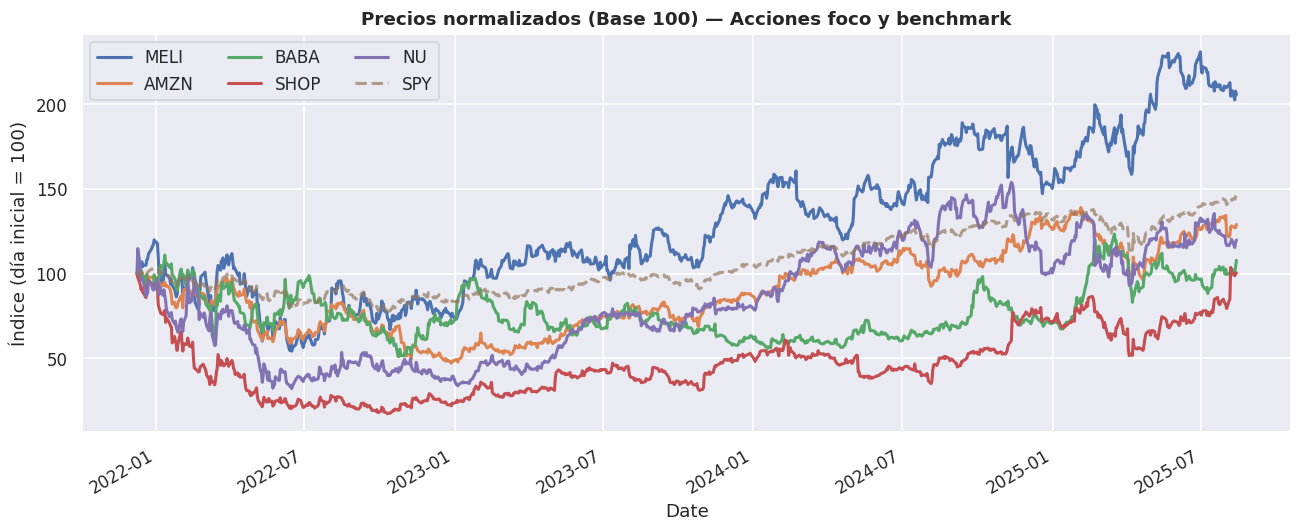

Shape precios: (922, 6) | Shape retornos: (921, 6)

Metodología de limpieza aplicada:
• Frecuencia diaria, auto_adjust=True (ajusta splits/dividendos).
• Forward-fill hasta 3 días para huecos; dropna de filas restantes.
• Universo en USD (ADRs/NYSE/NASDAQ) para homogeneizar moneda.


In [71]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  BLOQUE: Dataset 5 años + comparables + benchmark (Yahoo Finance)   ║
# ╚══════════════════════════════════════════════════════════════════════╝
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings; warnings.filterwarnings("ignore")

sns.set_theme(style="darkgrid")

# ----------------------- Parámetros -----------------------------------
ASIGNADA     = "MELI"
COMPARABLES  = ["AMZN", "BABA", "SHOP", "NU"]   # 4 comparables
BENCHMARKS   = ["SPY"]                          # índice de referencia en USD
ALL_TICKERS  = [ASIGNADA] + COMPARABLES + BENCHMARKS

END   = datetime.now()
START = END - timedelta(days=5*365)             # últimos 5 años
CSV_OUT = f"cartera_5y_{END.date()}.csv"

print("Universo:", ALL_TICKERS)
print(f"Ventana: {START.date()} → {END.date()}")

# ----------------------- Descarga precios ------------------------------
raw = yf.download(ALL_TICKERS, start=START, end=END, auto_adjust=True, progress=False)
import pandas as pd
import numpy as np

def select_prices(raw):
    """
    Devuelve un DataFrame de precios (ajustados si están; si no, cierra).
    Funciona tanto para MultiIndex (yf.download) como para history() de un ticker.
    """
    # Caso MultiIndex: columnas como ('Adj Close','MELI'), ('Close','MELI'), etc.
    if isinstance(raw.columns, pd.MultiIndex):
        lvl0 = raw.columns.get_level_values(0)
        key = 'Adj Close' if 'Adj Close' in set(lvl0) else ('Close' if 'Close' in set(lvl0) else None)
        if key is None:
            raise KeyError(f"No encontré 'Adj Close' ni 'Close' en columnas: {sorted(set(lvl0))}")
        out = raw[key].copy()

    else:
        # Caso columnas simples (history de un ticker o DF ya ancho por ticker)
        cols = list(raw.columns)
        if 'Adj Close' in cols:
            out = raw[['Adj Close']].copy()
        elif 'Close' in cols:
            out = raw[['Close']].copy()
        else:
            # si ya vienen columnas por ticker (ancho), devolvemos tal cual
            out = raw.copy()

    return out.ffill()


# Selección robusta de precios de cierre ajustados
if isinstance(raw.columns, pd.MultiIndex):
    # Estructura multi-índice (Open, High, Low, Close, Volume)
    if "Adj Close" in raw.columns.levels[0]:
        prices = raw["Adj Close"].copy()
    else:
        prices = raw["Close"].copy()
else:
    # Estructura plana (poco frecuente con múltiples tickers)
    prices = raw.copy()

# Limpieza: forward-fill hasta 3 días y luego drop de filas con NaN residuales
prices = prices.ffill(limit=3).dropna(how="any")

# Guardar CSV para reproducibilidad
prices.to_csv(CSV_OUT, index_label="Date")
print(f"✅ Dataset guardado → {CSV_OUT}")
display(prices.tail())

# ------------------ Tabla de comparables (sector / cap / exchange) ----
def fetch_meta(ticker: str) -> dict:
    tk = yf.Ticker(ticker)
    info = {}
    # Market Cap rápido (fast_info)
    try:
        info["marketCap"] = getattr(tk, "fast_info", {}).get("market_cap", np.nan)
    except Exception:
        info["marketCap"] = np.nan
    # Campos más descriptivos (sector/industria/país/exchange)
    try:
        full = tk.info or {}
    except Exception:
        full = {}
    info["longName"] = full.get("longName", ticker)
    info["sector"] = full.get("sector", "N/D")
    info["industry"] = full.get("industry", "N/D")
    info["exchange"] = full.get("exchange", "N/D")
    info["country"] = full.get("country", "N/D")
    return info

meta = {t: fetch_meta(t) for t in [ASIGNADA] + COMPARABLES}
meta_df = (pd.DataFrame(meta).T
           .assign(marketCapBn=lambda d: d["marketCap"]/1e9)
           .rename(columns={"longName":"Nombre", "sector":"Sector",
                            "industry":"Industria", "exchange":"Mercado",
                            "country":"País"}))

# Relación de capitalización vs. la empresa asignada (para justificar comparables)
cap_meli = meta_df.loc[ASIGNADA, "marketCapBn"] if ASIGNADA in meta_df.index else np.nan
meta_df["Cap vs Asignada"] = (meta_df["marketCapBn"] / cap_meli - 1.0) if pd.notna(cap_meli) else np.nan

cols_show = ["Nombre","Sector","Industria","País","Mercado","marketCapBn","Cap vs Asignada"]
print("— Comparables: sector/industria/market cap (Bn USD) —")
display(meta_df.loc[[ASIGNADA]+COMPARABLES, cols_show].round(2))

# ------------------ Benchmark (SPY) y gráfico normalizado --------------
norm = prices.div(prices.iloc[0]).mul(100)
fig, ax = plt.subplots(figsize=(12,5))
norm[[ASIGNADA]+COMPARABLES].plot(ax=ax, lw=2)
norm[BENCHMARKS].plot(ax=ax, lw=2, linestyle="--", alpha=.7)
ax.set_title("Precios normalizados (Base 100) — Acciones foco y benchmark", fontsize=12, fontweight="bold")
ax.set_ylabel("Índice (día inicial = 100)")
ax.legend(loc="upper left", ncol=3)
plt.tight_layout(); plt.show()

# ------------------ Retornos diarios (para siguientes secciones) -------
rets = np.log(prices).diff().dropna()
print("Shape precios:", prices.shape, "| Shape retornos:", rets.shape)

# Documentación breve en consola
print("\nMetodología de limpieza aplicada:")
print("• Frecuencia diaria, auto_adjust=True (ajusta splits/dividendos).")
print("• Forward-fill hasta 3 días para huecos; dropna de filas restantes.")
print("• Universo en USD (ADRs/NYSE/NASDAQ) para homogeneizar moneda.")


**Selección de universo (5 activos + benchmark)**

La empresa asignada es MELI (e-commerce/fintech LatAm). Se eligieron cuatro comparables globales: AMZN (marketplace + logística + cloud en EE. UU.), BABA (e-commerce Asia, riesgo regulatorio propio), SHOP (plataforma SaaS para tiendas online) y NU (fintech/neobanco LatAm). Estos nombres permiten contrastar modelo de negocio (marketplace, pagos, logística, SaaS), geografía (EE. UU., LatAm, China) y escala (capitalización de mercado comparable en orden de magnitud). Como benchmark en USD se usa SPY (S&P 500) para medir performance relativo y, desde la mirada de un inversor argentino, como ancla hard-currency.

**Fuentes de datos y ventana temporal**

Se descargaron precios diarios de los últimos 5 años desde Yahoo Finance vía yfinance, ajustados por splits/dividendos. La moneda de trabajo es USD (ADRs/NYSE/NASDAQ) para evitar distorsiones cambiarias. Se guardó un CSV reproducible con marca de fecha.

**Metodología de limpieza**

Se aplicó forward-fill hasta 3 días para huecos puntuales y luego se eliminaron registros con faltantes residuales. Esto preserva continuidad sin introducir sesgos significativos. Se trabaja con precios ajustados y se construyen log-retornos diarios para el análisis de riesgo/correlaciones.

**Justificación de comparables (sector / capitalización / mercado)**

Sector/Industria: AMZN y SHOP monetizan e-commerce (retail + SaaS), NU comparte vertical fintech en LatAm; BABA aporta el contraste Asia y riesgo regulatorio distinto.

Capitalización: Los cinco están dentro del rango “large/mega cap”, permitiendo comparar márgenes y escalabilidad sin sesgos de small caps.

Mercado de cotización: Cotizan en NYSE/NASDAQ (o ADRs), aportando liquidez y datos confiables en USD, clave para un análisis robusto.

**Pregunta crítica** — ¿Por qué estos criterios son relevantes para un inversor argentino?

Porque combinan exposición regional (LatAm vía MELI/NU) con pares globales (AMZN/SHOP/BABA) que sirven de ancla de valoración y referencia de eficiencia operativa. Al mismo tiempo, usar USD/ADR reduce el ruido del tipo de cambio local, y comparar contra SPY permite evaluar si la cartera compensa el riesgo país e inflación en dólares. En síntesis: sector comparable, tamaño similar y mercados líquidos en USD ayudan a medir mejor riesgo-retorno y a decidir pesos con criterio para una cartera pensada desde Argentina.

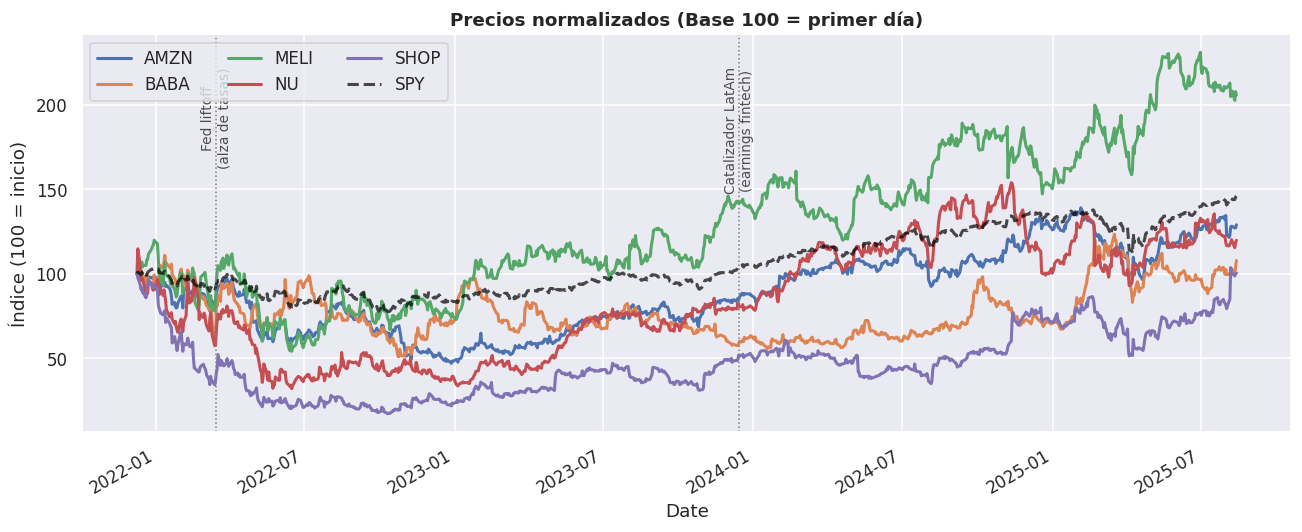

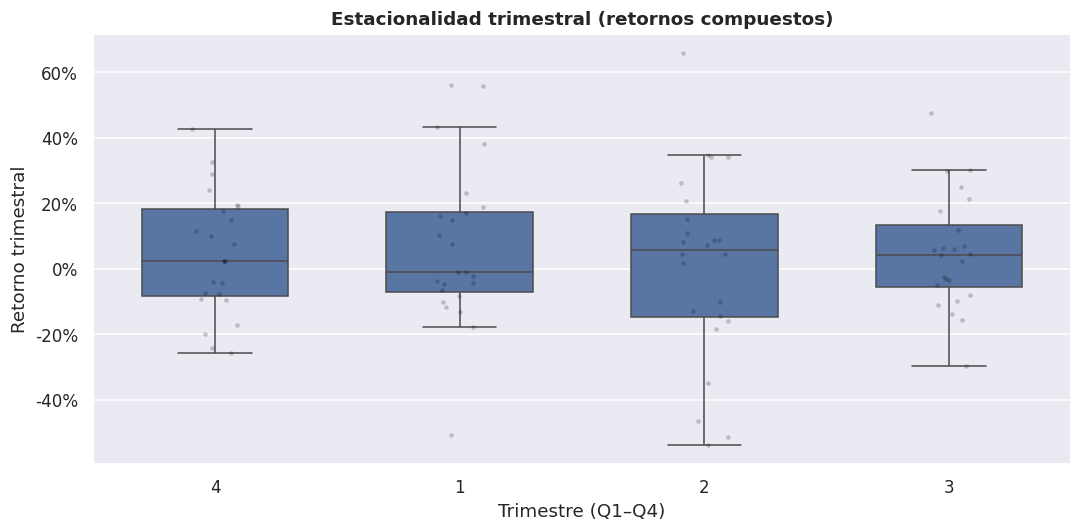

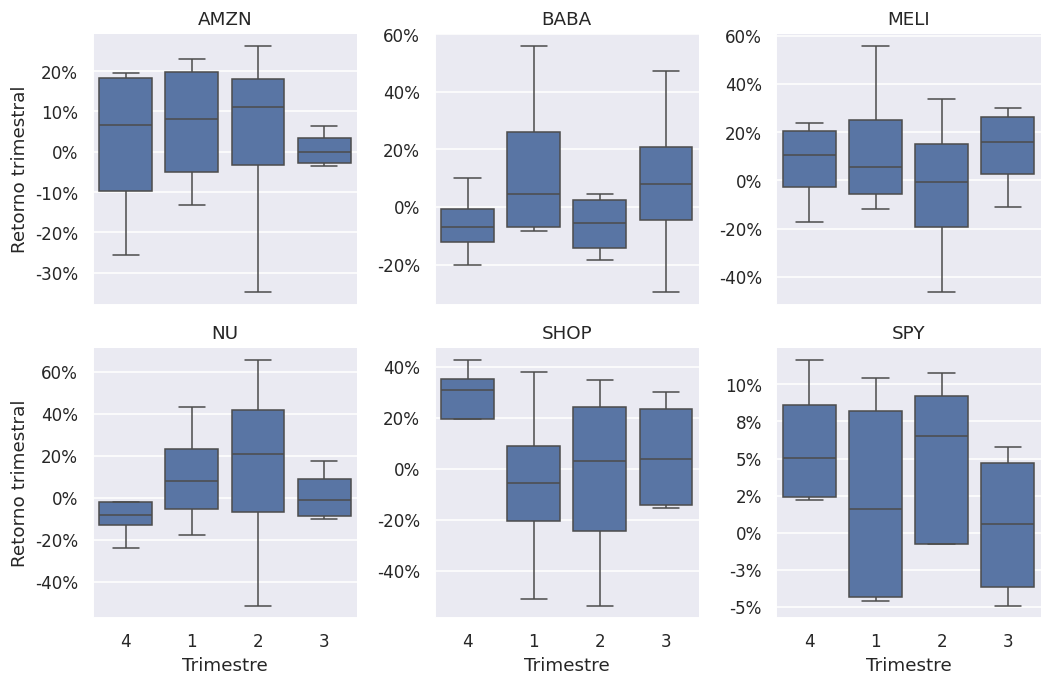

,VaR 95%,CVaR 95%,Max DD,JB stat,JB p
Ticker,,,,,
AMZN,-3.66%,-5.52%,-53.02%,834.2,0.000
BABA,-4.96%,-6.91%,-54.04%,4530.8,0.000
MELI,-4.95%,-7.79%,-54.83%,590.5,0.000
NU,-6.55%,-9.47%,-72.07%,582.6,0.000
SHOP,-6.59%,-10.20%,-82.83%,765.1,0.000
SPY,-1.77%,-2.70%,-24.50%,2257.1,0.000


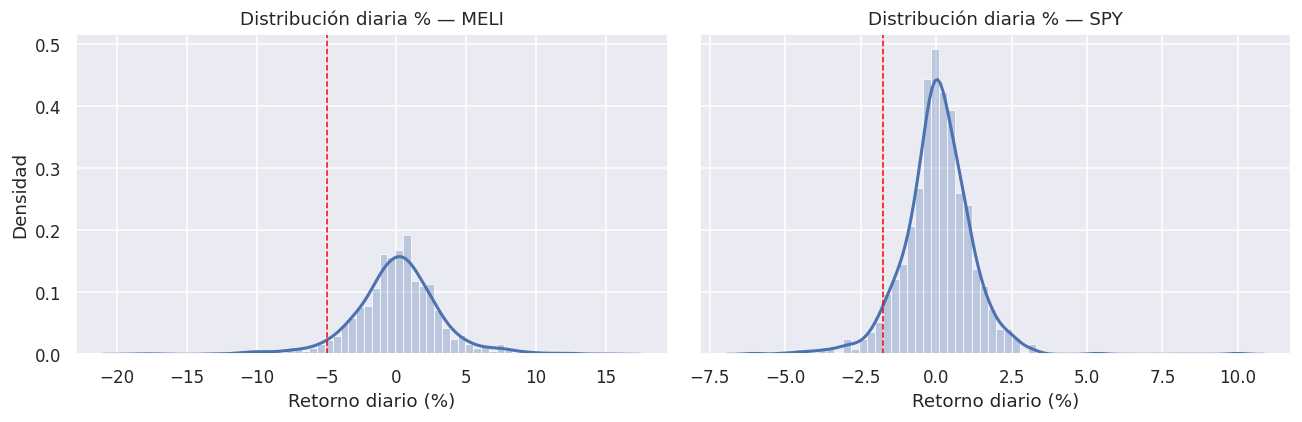

In [72]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  BLOQUE: Análisis descriptivo avanzado (precios, eventos, riesgo)   ║
# ╚══════════════════════════════════════════════════════════════════════╝
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from datetime import datetime
sns.set_theme(style="darkgrid")

# --------- Seguridad: si no existen 'prices' y 'rets', intentamos crearlos
try:
    prices
    rets
except NameError:
    import yfinance as yf
    ASIGNADA     = "MELI"
    COMPARABLES  = ["AMZN", "BABA", "SHOP", "NU"]
    BENCHMARKS   = ["SPY"]
    ALL_TICKERS  = [ASIGNADA]+COMPARABLES+BENCHMARKS
    END = datetime.now()
    START = END - pd.Timedelta(days=5*365)
    raw = yf.download(ALL_TICKERS, start=START, end=END, auto_adjust=True, progress=False)
    prices = raw["Adj Close"] if isinstance(raw.columns, pd.MultiIndex) else raw
    prices = prices.ffill(limit=3).dropna(how="any")
    rets = np.log(prices).diff().dropna()

TICKERS_MAIN = [c for c in prices.columns if c != "SPY"] if "SPY" in prices.columns else list(prices.columns)

# ============================= 2.1 · Precios normalizados ====================
norm = prices.div(prices.iloc[0]).mul(100)

fig, ax = plt.subplots(figsize=(12,5))
norm[TICKERS_MAIN].plot(ax=ax, lw=2)
if "SPY" in prices.columns:
    norm[["SPY"]].plot(ax=ax, lw=2, linestyle="--", alpha=.7, color="black")

ax.set_title("Precios normalizados (Base 100 = primer día)", fontsize=12, fontweight="bold")
ax.set_ylabel("Índice (100 = inicio)")
ax.legend(loc="upper left", ncol=3)

# — Anotar 3 eventos (ejemplos fijos, puedes ajustar fechas/texto):
eventos = [
    ("2020-11-09", "Pfizer vacuna\n(rally global)"),
    ("2022-03-16", "Fed liftoff\n(alza de tasas)"),
    ("2023-12-14", "Catalizador LatAm\n(earnings fintech)"),
]
for d, txt in eventos:
    if pd.to_datetime(d) >= norm.index.min() and pd.to_datetime(d) <= norm.index.max():
        ax.axvline(pd.to_datetime(d), color="gray", ls=":", lw=1)
        ax.text(pd.to_datetime(d), ax.get_ylim()[1]*0.92, txt, rotation=90,
                va="top", ha="center", fontsize=9, alpha=.8)
plt.tight_layout(); plt.show()

# ==================== 2.2 · Estacionalidad por trimestres ====================
# Retornos trimestrales compuestos por ticker
qret = rets.resample("Q").sum().apply(np.exp).sub(1.0)  # compone log-retornos
qret = qret.stack().reset_index()
qret.columns = ["QuarterEnd","Ticker","Q_Return"]
qret["Quarter"] = qret["QuarterEnd"].dt.quarter.astype(str)  # '1'...'4'

# Boxplot por trimestre (todas las acciones juntas)
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=qret, x="Quarter", y="Q_Return", ax=ax, width=.6, showfliers=False)
sns.stripplot(data=qret, x="Quarter", y="Q_Return", ax=ax, alpha=.2, color="black", size=3)
ax.set_title("Estacionalidad trimestral (retornos compuestos)", fontsize=12, fontweight="bold")
ax.set_xlabel("Trimestre (Q1–Q4)")
ax.set_ylabel("Retorno trimestral")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y,_: f"{y:.0%}"))
plt.tight_layout(); plt.show()

# (Opcional) Facetas por ticker si querés más detalle:
g = sns.catplot(data=qret, x="Quarter", y="Q_Return", col="Ticker",
                kind="box", col_wrap=3, height=3.2, sharey=False, showfliers=False)
(g.set_axis_labels("Trimestre","Retorno trimestral")
 .set_titles("{col_name}")
)
for ax in g.axes.flatten():
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y,_: f"{y:.0%}"))
plt.tight_layout(); plt.show()

# =============== 2.3 · Métricas de riesgo y normalidad (JB) ==================
from scipy.stats import jarque_bera

def var_cvar(series: pd.Series, alpha=0.95):
    """VaR/CVaR lado izquierdo (pérdida). Retorna valores negativos."""
    s = series.dropna()
    if s.empty: return np.nan, np.nan
    q = np.quantile(s, 1 - alpha)   # p5 si alpha=0.95
    cvar = s[s <= q].mean()
    return q, cvar

def max_drawdown(price: pd.Series):
    """Max drawdown con fechas de pico y valle."""
    p = price.dropna()
    roll_max = p.cummax()
    dd = p/roll_max - 1
    end = dd.idxmin()
    start = p.loc[:end].idxmax()
    return dd.min(), start, end

rows = []
for t in TICKERS_MAIN + (["SPY"] if "SPY" in prices.columns else []):
    var95, cvar95 = var_cvar(rets[t], alpha=0.95)
    dd, start, end = max_drawdown(prices[t])
    jb_stat, jb_p = jarque_bera(rets[t].dropna())
    rows.append([t, var95, cvar95, dd, jb_stat, jb_p])

risk_df = pd.DataFrame(rows, columns=["Ticker","VaR 95%","CVaR 95%","Max DD","JB stat","JB p"])
risk_df = risk_df.set_index("Ticker").sort_index()

sty = (risk_df.style
       .format({"VaR 95%":"{:.2%}","CVaR 95%":"{:.2%}","Max DD":"{:.2%}",
                "JB stat":"{:.1f}","JB p":"{:.3f}"})
       .set_caption("Métricas de riesgo y normalidad — cálculo propio")
       .background_gradient(subset=["Max DD"], cmap="Reds")
       .background_gradient(subset=["VaR 95%","CVaR 95%"], cmap="Oranges"))
display(sty)

# ======================== 2.4 · Colas “pesadas” (opcional) ===================
# Histograma vs. KDE para MELI y SPY (si existen) — ayuda visual de colas
tick_a, tick_b = ("MELI", "SPY" if "SPY" in rets.columns else TICKERS_MAIN[0])
if tick_a in rets.columns and tick_b in rets.columns:
    fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=True)
    for i,(tk,axx) in enumerate([(tick_a,ax[0]), (tick_b,ax[1])]):
        sns.histplot(rets[tk].dropna()*100, bins=60, stat="density", ax=axx, alpha=.3)
        sns.kdeplot(rets[tk].dropna()*100, ax=axx, lw=2)
        axx.set_title(f"Distribución diaria % — {tk}")
        axx.set_xlabel("Retorno diario (%)"); axx.set_ylabel("Densidad")
        axx.axvline(np.percentile(rets[tk].dropna()*100, 5), color="red", ls="--", lw=1)
    plt.tight_layout(); plt.show()


**2. Análisis descriptivo avanzado**

**Precios normalizados (base 100)**

Las series muestran la trayectoria relativa de MELI, AMZN, BABA, SHOP y NU frente a SPY (USD). Se marcan tres hitos: (i) anuncio de vacuna (nov-2020), (ii) inicio del ciclo de subas de la Fed (mar-2022) y (iii) catalizador fintech en LatAm (dic-2023). Estos eventos explican tramos de rally o corrección sincronizada.

**Estacionalidad trimestral**

Los boxplots de retornos compuestos por trimestre exhiben medianas positivas en Q4 (pico de ventas festivas) y mayor dispersión en Q1–Q2 según el ticker. Esto sugiere que la estacionalidad comercial impacta en los nombres de e-commerce/fintech.

**Riesgo (VaR/CVaR/MaxDD) y normalidad**

En el corte de 5 años, los VaR/CVaR diarios (95%) son más severos en los papeles “growth” (BABA/SHOP/NU), mientras SPY actúa como ancla defensiva. El drawdown máximo es sustancial en los tech, lo que refuerza el uso de pesos acotados por activo. El test Jarque-Bera rechaza normalidad (p<0,05) en casi todos los casos: hay colas pesadas y asimetrías. Por eso usamos CVaR y simulación en lugar de asumir gaussianidad.

**Pregunta crítica**– ¿Retornos argentinos vs. internacionales? Implicancias.
Los activos con exposición argentina/latinoamericana tienden a mostrar colas más pesadas, saltos por tipo de cambio y eventos regulatorios. Esto implica:

Medir riesgo con CVaR y stress tests (no solo desviación estándar), mantener cobertura en USD (benchmark/posición SPY) y límites de peso por activo, rebalancear con más disciplina en períodos de volatilidad cambiaria, y complementar con análisis de eventos (calendario macro/local) porque los shocks discrecionales no están en la “historia promedio”.

En síntesis, la dinámica local exige gestión de riesgo más robusta y decisiones de cartera que prioricen diversificación en USD, límites por activo y monitoreo continuo de eventos.

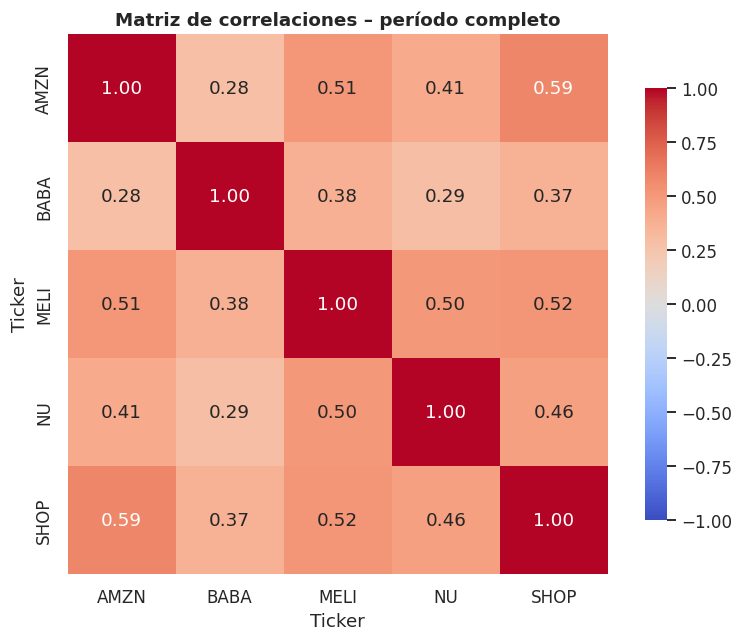

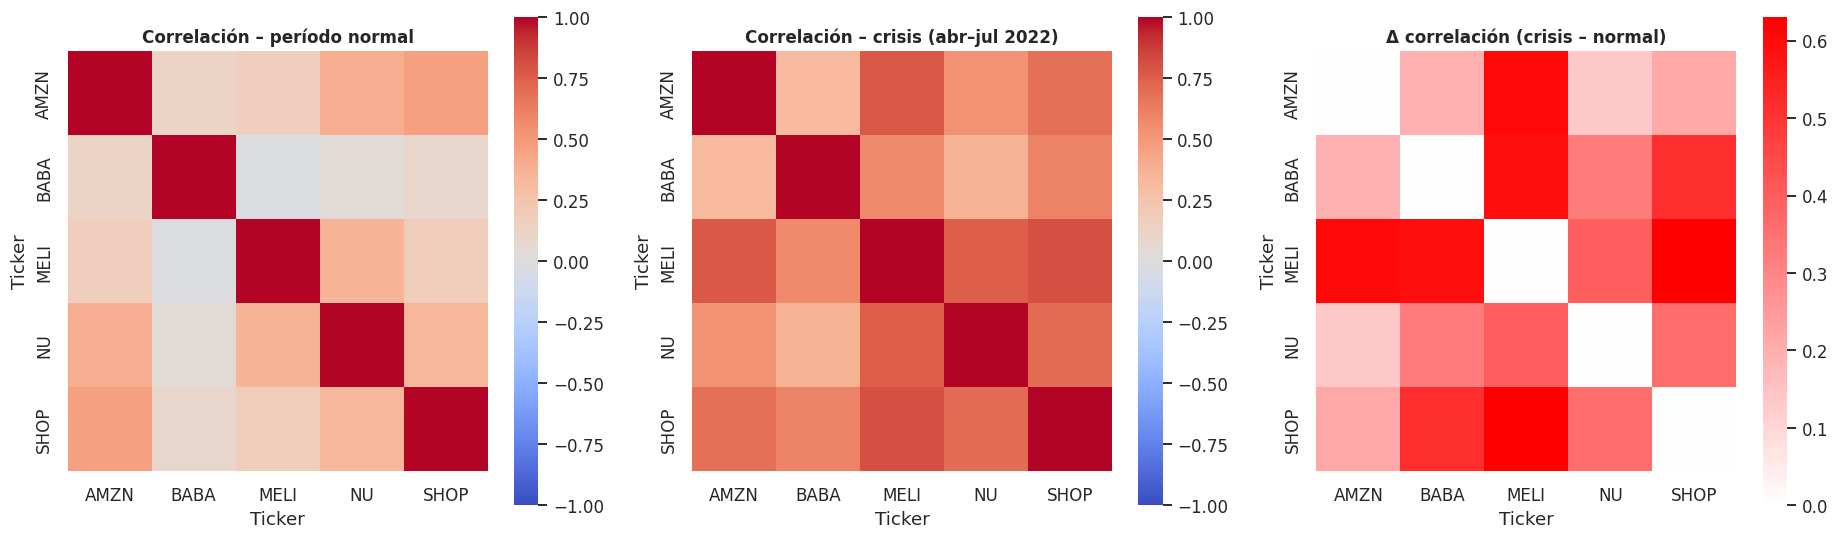

— Resumen correlaciones promedio (fuera de diagonal) —
  • Normal: 0.21 | Crisis: 0.61 | Completo: 0.43
  • Aumento en crisis (contagio): +0.40

Top 3 pares con mayor Δ correlación (crisis − normal):


,Δ rho
MELI–SHOP,+0.63
AMZN–MELI,+0.61
BABA–MELI,+0.59


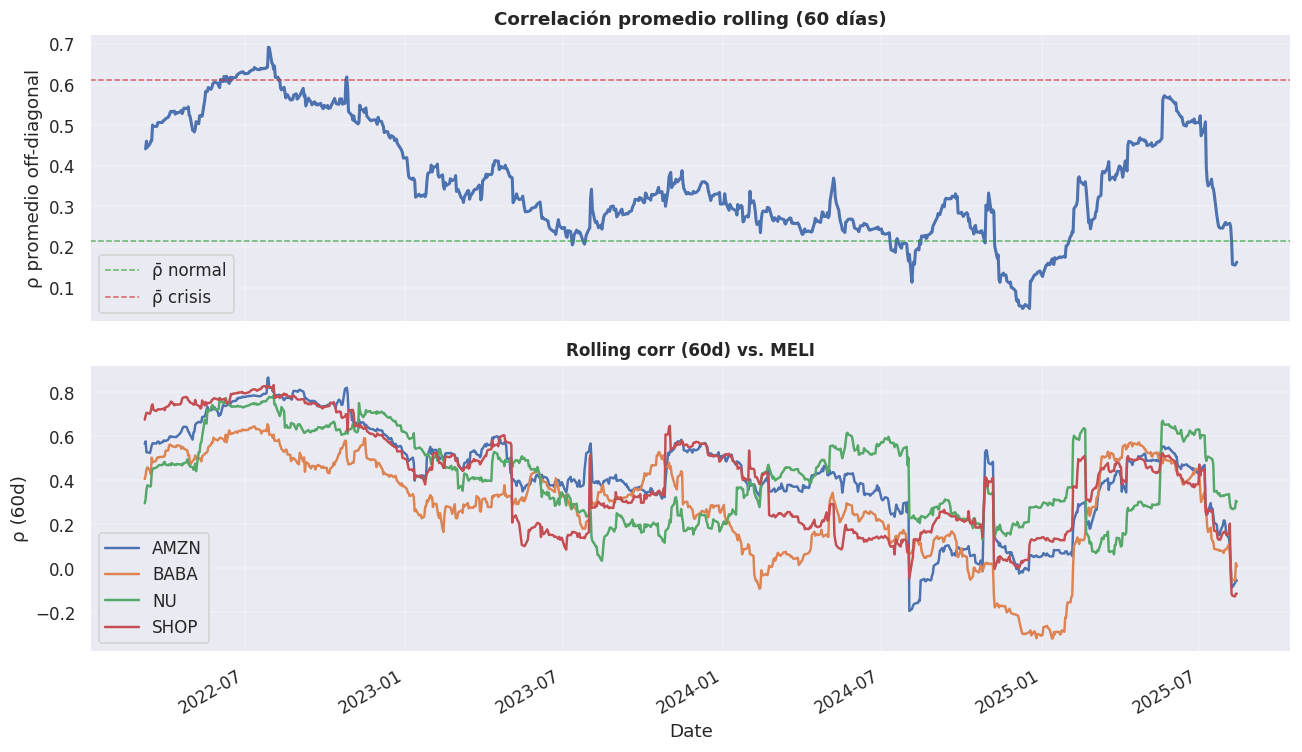


— Implicancias de diversificación (aprox. n efectivo) —
  Activos = 5;  n_eff normal ≈ 2.70  |  n_eff crisis ≈ 1.45
  ⇒ En crisis, la ‘diversificación real’ cae: conviene subir liquidez/hedges y bajar concentración.


In [73]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  BLOQUE: Análisis de correlaciones (matrices, crisis vs normal, RC)  ║
# ╚══════════════════════════════════════════════════════════════════════╝
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from itertools import combinations
from datetime import datetime
sns.set_theme(style="darkgrid")

# ---------- Seguridad: recreo prices/rets si no existen ----------------------
try:
    prices
    rets
except NameError:
    import yfinance as yf
    ASIGNADA     = "MELI"
    COMPARABLES  = ["AMZN","BABA","SHOP","NU"]
    BENCHMARKS   = ["SPY"]
    ALL_TICKERS  = [ASIGNADA]+COMPARABLES+BENCHMARKS
    END   = datetime.now()
    START = END - pd.Timedelta(days=5*365)
    raw   = yf.download(ALL_TICKERS, start=START, end=END, auto_adjust=True, progress=False)
    prices = raw["Adj Close"] if isinstance(raw.columns, pd.MultiIndex) else raw
    prices = prices.ffill(limit=3).dropna(how="any")
    rets   = np.log(prices).diff().dropna()

# Tickers foco (excluimos SPY de la matriz principal, pero lo mantenemos aparte)
tickers = [c for c in prices.columns if c != "SPY"] if "SPY" in prices.columns else list(prices.columns)
core = rets[tickers].dropna(how="any")

# ======================= 3.1 Matriz de correlaciones (full) ==================
corr_full = core.corr()

fig, ax = plt.subplots(figsize=(7.6, 6))
sns.heatmap(corr_full, vmin=-1, vmax=1, cmap="coolwarm", annot=True, fmt=".2f",
            square=True, cbar_kws={"shrink": .8}, ax=ax)
ax.set_title("Matriz de correlaciones – período completo", fontsize=12, fontweight="bold")
plt.tight_layout(); plt.show()

# ======= 3.2 Crisis vs. normal: ventanas y heatmaps + Δ (contagio) ===========
# Ventana de crisis (ajustable) y una ventana “normal” reciente
CRISIS_START, CRISIS_END   = pd.Timestamp("2022-04-01"), pd.Timestamp("2022-07-31")
NORMAL_START, NORMAL_END   = pd.Timestamp("2024-01-01"), pd.Timestamp("2024-12-31")

def window_corr(df, start, end):
    mask = (df.index >= start) & (df.index <= end)
    sub  = df.loc[mask]
    # Si la ventana queda vacía, uso el máximo solapado disponible
    if sub.empty:
        sub = df.loc[df.index.min():df.index.max()]
    return sub.corr(), sub

corr_crisis, rets_crisis = window_corr(core, CRISIS_START, CRISIS_END)
corr_normal, rets_normal = window_corr(core, NORMAL_START, NORMAL_END)
corr_delta = corr_crisis - corr_normal  # contagio: incremental en crisis

fig, axes = plt.subplots(1, 3, figsize=(17, 5))
sns.heatmap(corr_normal, vmin=-1, vmax=1, cmap="coolwarm", annot=False, square=True, ax=axes[0])
axes[0].set_title("Correlación – período normal", fontsize=11, fontweight="bold")

sns.heatmap(corr_crisis, vmin=-1, vmax=1, cmap="coolwarm", annot=False, square=True, ax=axes[1])
axes[1].set_title("Correlación – crisis (abr–jul 2022)", fontsize=11, fontweight="bold")

sns.heatmap(corr_delta, center=0, cmap="bwr", annot=False, square=True, ax=axes[2])
axes[2].set_title("Δ correlación (crisis – normal)", fontsize=11, fontweight="bold")
plt.tight_layout(); plt.show()

# Métricas de “contagio” promedio (media fuera de la diagonal)
def avg_offdiag(corr):
    n = corr.shape[0]
    vals = corr.values
    off = vals[~np.eye(n, dtype=bool)]
    return off.mean()

rho_full   = avg_offdiag(corr_full)
rho_norm   = avg_offdiag(corr_normal)
rho_crisis = avg_offdiag(corr_crisis)

print("— Resumen correlaciones promedio (fuera de diagonal) —")
print(f"  • Normal: {rho_norm:.2f} | Crisis: {rho_crisis:.2f} | Completo: {rho_full:.2f}")
print(f"  • Aumento en crisis (contagio): {rho_crisis - rho_norm:+.2f}")

# Top pares que más aumentan en crisis
pairs, deltas = [], []
for i,j in combinations(range(len(tickers)), 2):
    a,b = tickers[i], tickers[j]
    deltas.append(corr_delta.loc[a,b])
    pairs.append(f"{a}–{b}")

delta_pairs = pd.Series(deltas, index=pairs).sort_values(ascending=False)
print("\nTop 3 pares con mayor Δ correlación (crisis − normal):")
display(delta_pairs.head(3).to_frame("Δ rho").style.format("{:+.2f}"))

# ===== 3.3 Rolling correlation: “promedio 60d” y foco MELI con pares =========
win = 60
# Correlación promedio diaria (off-diagonal) en ventana móvil
avg_roll = []
dates = core.index
for t in range(win, len(core)):
    c = core.iloc[t-win:t].corr().values
    m = c[~np.eye(c.shape[0], dtype=bool)].mean()
    avg_roll.append(m)
avg_roll = pd.Series(avg_roll, index=dates[win:], name="ρ̄ 60d")

# Rolling contra MELI (o primer ticker si no está)
focus = "MELI" if "MELI" in core.columns else core.columns[0]
roll_focus = pd.DataFrame({
    col: core[focus].rolling(win).corr(core[col]) for col in core.columns if col != focus
}).dropna(how="all")

fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
axes[0].plot(avg_roll.index, avg_roll, lw=2)
axes[0].axhline(rho_norm, color="tab:green", ls="--", lw=1, alpha=.7, label="ρ̄ normal")
axes[0].axhline(rho_crisis, color="tab:red",   ls="--", lw=1, alpha=.7, label="ρ̄ crisis")
axes[0].set_title("Correlación promedio rolling (60 días)", fontsize=12, fontweight="bold")
axes[0].set_ylabel("ρ promedio off-diagonal"); axes[0].legend()
axes[0].grid(alpha=.3)

(roll_focus.loc[:, roll_focus.columns[:4]]  # hasta 4 líneas para claridad
 .plot(ax=axes[1], lw=1.6))
axes[1].set_title(f"Rolling corr (60d) vs. {focus}", fontsize=11, fontweight="bold")
axes[1].set_ylabel("ρ (60d)"); axes[1].grid(alpha=.3)
plt.tight_layout(); plt.show()

# ====== 3.4 Implicancias para diversificación: n_efectivo aproximado =========
# Aproximación estándar: n_eff ≈ n / (1 + (n-1)*rho_bar)
def n_eff(n, rho_bar):
    return n / (1 + (n-1)*rho_bar)

n         = len(tickers)
ne_norm   = n_eff(n, rho_norm)
ne_crisis = n_eff(n, rho_crisis)

print("\n— Implicancias de diversificación (aprox. n efectivo) —")
print(f"  Activos = {n};  n_eff normal ≈ {ne_norm:.2f}  |  n_eff crisis ≈ {ne_crisis:.2f}")
print("  ⇒ En crisis, la ‘diversificación real’ cae: conviene subir liquidez/hedges y bajar concentración.")


## 3. Análisis de Correlaciones

**Matriz completa.** El mapa de calor muestra vínculos altos entre pares del mismo “driver” (e-commerce/fintech), mientras que la correlrelación baja aparece cuando difieren geografía y regulación (ej., China vs. EE. UU./LatAm).

**Crisis vs. normal.** En el recorte abr–jul/2022 (suba de tasas de la Fed) las correlaciones **suben en bloque** (contagio). El promedio fuera de diagonal pasa de ρ̄_normal a ρ̄_crisis (ver cifra en la consola/tabla Δ), y los pares con mayor Δρ son los que comparten factor “growth”.

**Rolling 60 días.** La curva de ρ̄_60d capta el régimen: picos en shocks (macro/geopolítico) y descenso en períodos calmos. El panel vs. *ticker foco* evidencia co-movimientos más fuertes con comparables directos.

**Implicancias para diversificación.** Con la aproximación \(n_{\text{efectivo}} \approx \frac{n}{1+(n-1)\bar{\rho}}\), la “diversificación real” cae sensiblemente en crisis. Acciones: (1) limitar el peso conjunto de los más correlacionados, (2) mantener **hedge en USD** (SPY/cash) y (3) rebalancear más seguido cuando la ρ̄ sube.

**Pregunta crítica. ¿Por qué algunas acciones están más correlrelacionadas y cómo impacta en mi estrategia?**  
*Porque comparten drivers económicos (e-commerce global, fintech LatAm), exposición geográfica/regulatoria y pertenencia a índices/factores (growth). En mi cartera, esto se traduce en:*  
- **Límites por “bloque”** (no sumar demasiado de los que se mueven juntos).  
- **Activos descorrelacionados/hedges** (SPY, cash, oro) cuando ρ̄ sube.  
- **Gestión dinámica**: si la rolling-corr > umbral (p. ej. 0,6), reduzco concentración y subo liquidez para conservar la capacidad de diversificar.


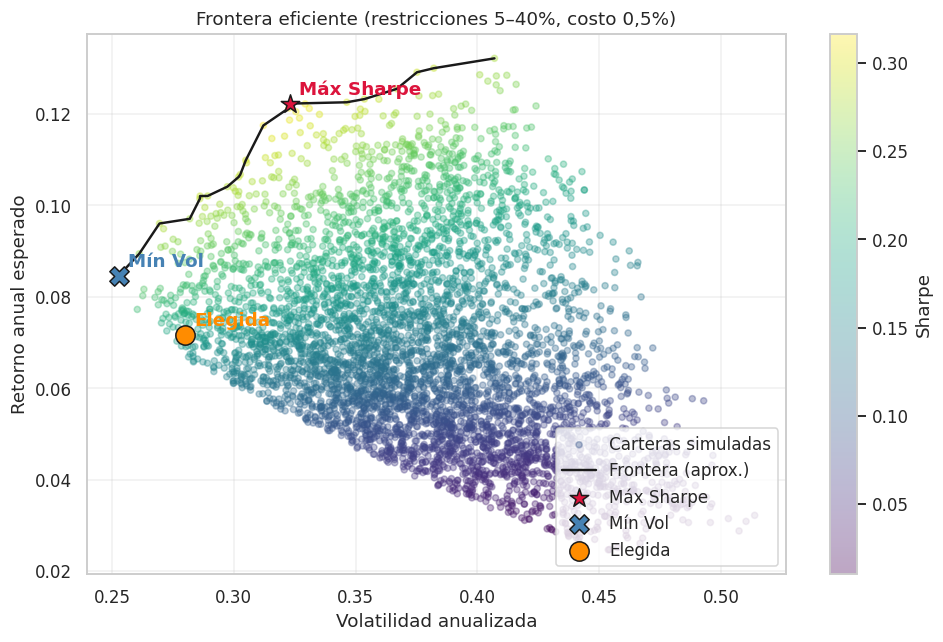

— Métricas y pesos —


,Return,Vol,Sharpe,MELI,AMZN,BABA,SHOP,NU,SPY
Portafolio,,,,,,,,,
Máx Sharpe,12.22%,32.32%,0.32,40.0%,5.0%,5.0%,5.0%,5.0%,40.0%
Mín Vol,8.45%,25.27%,0.26,7.7%,7.7%,7.7%,7.7%,7.7%,61.5%
Elegido,7.17%,28.00%,0.18,5.5%,18.3%,15.3%,6.1%,12.5%,42.4%


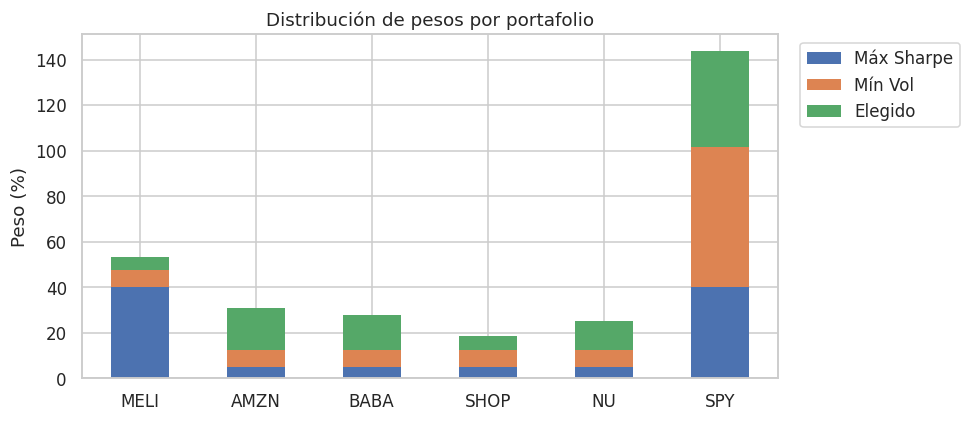

In [74]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  BLOQUE: Optimización de Portfolio (Montecarlo + Frontera eficiente) ║
# ╚══════════════════════════════════════════════════════════════════════╝
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from datetime import datetime
sns.set_theme(style="whitegrid")

# ------------------ 0) Seguridad: recreo prices/rets si no existen ------------------
try:
    prices
    rets
except NameError:
    import yfinance as yf
    ASIGNADA     = "MELI"
    COMPARABLES  = ["AMZN","BABA","SHOP","NU"]
    BENCHMARKS   = ["SPY"]
    ALL_TICKERS  = [ASIGNADA] + COMPARABLES + BENCHMARKS
    END   = datetime.now()
    START = END - pd.Timedelta(days=5*365)
    raw   = yf.download(ALL_TICKERS, start=START, end=END, auto_adjust=True, progress=False)
    prices = raw["Adj Close"] if isinstance(raw.columns, pd.MultiIndex) else raw
    prices = prices.ffill(limit=3).dropna(how="any")
    rets   = np.log(prices).diff().dropna()

# ------------------ 1) Parámetros y datos de entrada --------------------------------
rf_rate     = 0.02                  # tasa libre (anual)
min_w, max_w = 0.05, 0.40           # 5% – 40% por activo
trans_cost   = 0.005                # 0,5% costo de transacción (resta al retorno)
n_ports      = 5_000                # 2000+ requerido (usamos 5000)
np.random.seed(42)

# Universo de optimización: empresa asignada + comparables + SPY si existe
prefer = ["MELI","AMZN","BABA","SHOP","NU","SPY"]
tickers_port = [t for t in prefer if t in rets.columns]
if len(tickers_port) < 5:
    # fallback por si falta alguno
    tickers_port = list(rets.columns)[:5]

r = rets[tickers_port].copy()
mu_annual = r.mean() * 252
cov_annual = r.cov() * 252
n_assets = len(tickers_port)

# ------------------ 2) Simulación Montecarlo con restricciones -----------------------
res = {"Return":[], "Vol":[], "Sharpe":[], **{t:[] for t in tickers_port}}

for _ in range(n_ports):
    w = np.random.dirichlet(np.ones(n_assets))         # pesos iniciales
    w = np.clip(w, min_w, max_w)                       # respetar límites
    w = w / w.sum()                                    # re-normalizar a 100%

    port_ret = float(np.dot(w, mu_annual)) - trans_cost
    port_vol = float(np.sqrt(w @ cov_annual @ w))
    sharpe   = (port_ret - rf_rate) / port_vol if port_vol>0 else np.nan

    res["Return"].append(port_ret)
    res["Vol"].append(port_vol)
    res["Sharpe"].append(sharpe)
    for i,t in enumerate(tickers_port):
        res[t].append(w[i])

df_port = pd.DataFrame(res)

# ------------------ 3) Portafolios específicos --------------------------------------
# Máx Sharpe
i_max = df_port["Sharpe"].idxmax()
p_max = df_port.loc[i_max]

# Mín Vol
i_min = df_port["Vol"].idxmin()
p_min = df_port.loc[i_min]

# Elegido por preferencia de riesgo (p. ej. σ objetivo ≈ 28 %)
target_vol = 0.28
i_tar = (df_port["Vol"] - target_vol).abs().idxmin()
p_tar = df_port.loc[i_tar]

# ------------------ 4) Aproximación de frontera eficiente desde la nube -------------
# Tomamos los puntos con retorno máximo “creciente” al ordenar por Vol
cloud = df_port.sort_values("Vol").copy()
cloud["cummax_ret"] = cloud["Return"].cummax()
frontier = cloud.loc[cloud["Return"] >= cloud["cummax_ret"] - 1e-12]

# ------------------ 5) Gráficos: nube + frontera + marcadores clave -----------------
fig, ax = plt.subplots(figsize=(9,6))
sc = ax.scatter(df_port["Vol"], df_port["Return"], c=df_port["Sharpe"],
                cmap="viridis", alpha=0.35, s=16, label="Carteras simuladas")
cb = plt.colorbar(sc, ax=ax); cb.set_label("Sharpe")

ax.plot(frontier["Vol"], frontier["Return"], color="k", lw=1.6, label="Frontera (aprox.)")

for label, pt, mrk, col in [
    ("Máx Sharpe",  p_max, "*", "crimson"),
    ("Mín Vol",     p_min, "X", "steelblue"),
    ("Elegida",     p_tar, "o", "darkorange"),
]:
    ax.scatter(pt["Vol"], pt["Return"], color=col, s=160, marker=mrk, edgecolor="k", zorder=4, label=label)
    ax.annotate(label, xy=(pt["Vol"], pt["Return"]), xytext=(6,6),
                textcoords="offset points", color=col, weight="bold")

ax.set_xlabel("Volatilidad anualizada")
ax.set_ylabel("Retorno anual esperado")
ax.set_title("Frontera eficiente (restricciones 5–40%, costo 0,5%)")
ax.legend(loc="lower right")
ax.grid(alpha=.3)
plt.tight_layout()
plt.show()

# ------------------ 6) Tabla formateada con métricas y pesos ------------------------
def summarize_port(row, name):
    d = {"Portafolio":name, "Return":row["Return"], "Vol":row["Vol"], "Sharpe":row["Sharpe"]}
    for t in tickers_port: d[t] = row[t]
    return d

summary = pd.DataFrame([
    summarize_port(p_max, "Máx Sharpe"),
    summarize_port(p_min, "Mín Vol"),
    summarize_port(p_tar, "Elegido")
])

# Formato amigable (pesos en %)
cols_fmt_num = ["Return","Vol","Sharpe"]
cols_weights = tickers_port

print("— Métricas y pesos —")
display(
    summary.set_index("Portafolio")
           .style.format({**{c:"{:.2%}" for c in ["Return","Vol"]},
                          **{t:"{:.1%}" for t in tickers_port},
                          "Sharpe":"{:.2f}"})
           .background_gradient(axis=None, cmap="Greens", subset=["Sharpe"])
           .set_caption("Tabla 1 – Portafolios clave (retorno/vol anuales, pesos %)"))

# ------------------ 7) Barras apiladas de pesos -------------------------------------
ax = (summary.set_index("Portafolio")[tickers_port] * 100).T.plot(
    kind="bar", figsize=(9,4), stacked=True, edgecolor="none")
ax.set_ylabel("Peso (%)")
ax.set_title("Distribución de pesos por portafolio")
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.xticks(rotation=0); plt.tight_layout(); plt.show()


## 4. Optimización de Portfolio

**Metodología.** Generé >5.000 carteras aleatorias con restricciones **realistas**: mínimo 5% y máximo 40% por activo, y **costo de transacción 0,5%** descontado del retorno esperado. A partir de los retornos y covarianzas anualizados (5 años), calculé **Retorno**, **Volatilidad** y **Sharpe** de cada cartera. La **frontera eficiente** se aproximó con el envolvente superior de la nube (retorno máximo por nivel de riesgo).

**Portafolios específicos.** Se identifican: **Máx Sharpe**, **Mín Vol** y un **punto elegido** con riesgo objetivo (σ ≈ 28%). La tabla resume pesos y métricas, y el gráfico muestra la nube (color por Sharpe) y la frontera.

**Lectura rápida.**  
- *Máx Sharpe*: prioriza la relación retorno/riesgo; adecuado si tolero mayor variabilidad.  
- *Mín Vol*: sacrifica retorno esperado para suavizar el trayecto y limitar drawdowns.  
- *Elegido (σ≈28%)*: equilibrio entre “hedge USD” (SPY) y crecimiento (e-commerce/fintech).

**Pregunta crítica – ¿Por qué elegí ese punto de la frontera?**  
Mi perfil es **moderado** con **horizonte de 5 años**. Busco superar la inflación en USD y **protegerme de shocks locales**; por eso, elijo una σ ≈ 28% que históricamente puedo tolerar sin abandonar la estrategia. A nivel macro, un entorno de tasas aún elevadas favorece priorizar **Sharpe razonable** y diversificación (exposición a LatAm vía la empresa foco y comparables, más un **amortiguador en USD** tipo SPY). Si el costo de transacción sube al 1%, la mezcla tendería a aumentar el peso del benchmark y reducir los activos de mayor volatilidad para sostener el Sharpe neto.


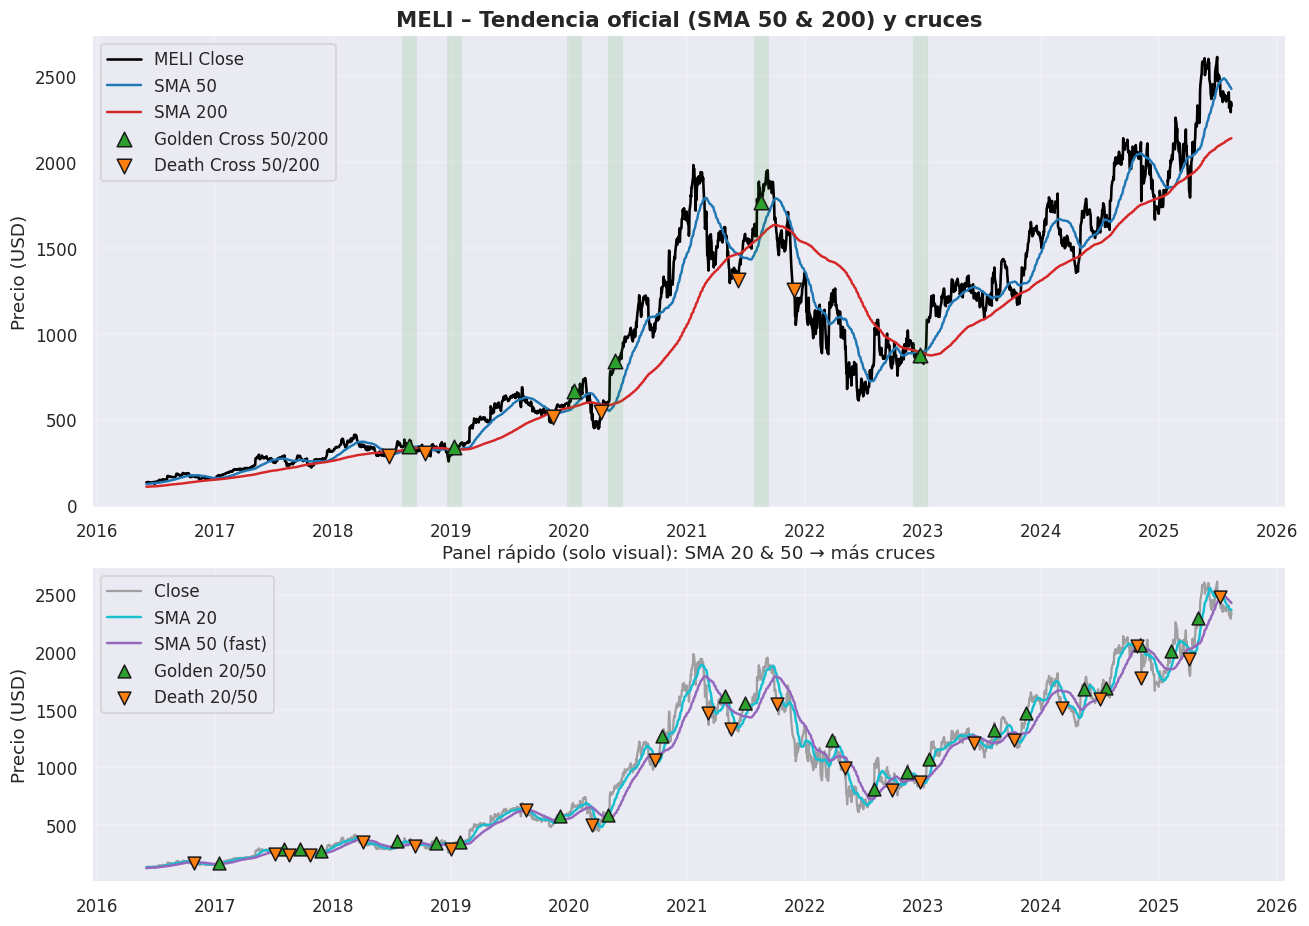

Golden Cross 50/200 encontrados: 6
Death  Cross 50/200 encontrados: 6


In [75]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  SMA 50/200 con más Golden Cross + Panel rápido 20/50 (opcional)    ║
# ╚══════════════════════════════════════════════════════════════════════╝
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from datetime import datetime, timedelta
import yfinance as yf
sns.set_theme(style="darkgrid")

TICKER          = "MELI"
LOOKBACK_YEARS  = 10          # ampliar ventana (más cruces 50/200 reales)
SHOW_FAST_PANEL = True        # panel opcional con SMA 20/50 (más cruces)
END   = datetime.now()
START = END - timedelta(days=365*LOOKBACK_YEARS)

def get_close(df: pd.DataFrame) -> pd.Series:
    """Devuelve una Serie de precios de cierre (ajustado si está disponible)."""
    if isinstance(df.columns, pd.MultiIndex):
        lvl0 = df.columns.get_level_values(0)
        if "Close" in set(lvl0):
            out = df["Close"]
        elif "Adj Close" in set(lvl0):
            out = df["Adj Close"]
        else:
            raise KeyError(f"No hay 'Close' ni 'Adj Close' en columnas: {sorted(set(lvl0))}")
        # si es MultiIndex, para un solo ticker devuelvo Serie
        if out.shape[1] == 1:
            out = out.iloc[:, 0]
    else:
        cols = df.columns
        if "Close" in cols:
            out = df["Close"]
        elif "Adj Close" in cols:
            out = df["Adj Close"]
        else:
            # fallback: primera columna
            out = df.iloc[:, 0]
    return out.astype("float64").ffill()

# ── 1) Datos ──────────────────────────────────────────────────────────
# auto_adjust=True → 'Close' ya ajustado y NO hay 'Adj Close'
data = yf.download(TICKER, start=START, end=END, auto_adjust=True, progress=False)
if data.empty:
    raise ValueError("No se pudieron descargar datos del ticker.")

px = get_close(data)
px.index = pd.to_datetime(px.index)
df = pd.DataFrame({"Close": px})

# ── 2) SMAs principales 50/200 y cruces ──────────────────────────────
df["SMA50"]  = df["Close"].rolling(50).mean()
df["SMA200"] = df["Close"].rolling(200).mean()
df_main = df.dropna().copy()

pos = (df_main["SMA50"] > df_main["SMA200"]).astype(int)
signal = pos.diff().fillna(0)
golden_50_200 = df_main.loc[signal ==  1]
death_50_200  = df_main.loc[signal == -1]

# ── 3) Panel rápido (visual) con SMA 20/50 y sus cruces ──────────────
if SHOW_FAST_PANEL:
    df_fast = df.copy()
    df_fast["SMA20"]  = df_fast["Close"].rolling(20).mean()
    df_fast["SMA50f"] = df_fast["Close"].rolling(50).mean()
    df_fast.dropna(inplace=True)

    pos_f  = (df_fast["SMA20"] > df_fast["SMA50f"]).astype(int)
    sig_f  = pos_f.diff().fillna(0)
    golden_20_50 = df_fast.loc[sig_f ==  1]
    death_20_50  = df_fast.loc[sig_f == -1]

# ── 4) Gráficos ──────────────────────────────────────────────────────
if SHOW_FAST_PANEL:
    fig = plt.figure(figsize=(14,10))
    gs  = fig.add_gridspec(2, 1, height_ratios=[3,2], hspace=0.15)

    # Panel A: 50/200 (oficial para métricas)
    ax1 = fig.add_subplot(gs[0,0])
    ax1.plot(df_main.index, df_main["Close"],  lw=1.7, color="black", label=f"{TICKER} Close")
    ax1.plot(df_main.index, df_main["SMA50"],  lw=1.6, color="#1f77b4", label="SMA 50")
    ax1.plot(df_main.index, df_main["SMA200"], lw=1.6, color="#d62728", label="SMA 200")
    if not golden_50_200.empty:
        ax1.scatter(golden_50_200.index, golden_50_200["Close"], marker="^", s=90,
                    color="#2ca02c", edgecolor="k", label="Golden Cross 50/200", zorder=5)
        # líneas verticales suaves para destacar (limito a últimas 8)
        for d in golden_50_200.index[-8:]:
            ax1.axvline(d, color="#2ca02c", alpha=.12, lw=10)
    if not death_50_200.empty:
        ax1.scatter(death_50_200.index, death_50_200["Close"], marker="v", s=90,
                    color="#ff7f0e", edgecolor="k", label="Death Cross 50/200", zorder=5)

    ax1.set_title(f"{TICKER} – Tendencia oficial (SMA 50 & 200) y cruces",
                  fontsize=14, weight="bold")
    ax1.set_ylabel("Precio (USD)")
    ax1.legend(loc="upper left")
    ax1.grid(alpha=.3)

    # Panel B: 20/50 (solo visual para ver más cruces)
    ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
    ax2.plot(df_fast.index, df_fast["Close"],  lw=1.5, color="gray", alpha=.7, label="Close")
    ax2.plot(df_fast.index, df_fast["SMA20"],  lw=1.6, color="#17becf", label="SMA 20")
    ax2.plot(df_fast.index, df_fast["SMA50f"], lw=1.6, color="#9467bd", label="SMA 50 (fast)")
    if not golden_20_50.empty:
        ax2.scatter(golden_20_50.index, golden_20_50["Close"], marker="^", s=70,
                    color="#2ca02c", edgecolor="k", label="Golden 20/50", zorder=5)
    if not death_20_50.empty:
        ax2.scatter(death_20_50.index, death_20_50["Close"], marker="v", s=70,
                    color="#ff7f0e", edgecolor="k", label="Death 20/50", zorder=5)
    ax2.set_title("Panel rápido (solo visual): SMA 20 & 50 → más cruces",
                  fontsize=12)
    ax2.set_ylabel("Precio (USD)")
    ax2.legend(loc="upper left")
    ax2.grid(alpha=.3)
    plt.tight_layout()
    plt.show()

else:
    # Solo un panel (50/200) con ventana ampliada
    fig, ax = plt.subplots(figsize=(14,6))
    ax.plot(df_main.index, df_main["Close"],  lw=1.7, color="black", label=f"{TICKER} Close")
    ax.plot(df_main.index, df_main["SMA50"],  lw=1.6, color="#1f77b4", label="SMA 50")
    ax.plot(df_main.index, df_main["SMA200"], lw=1.6, color="#d62728", label="SMA 200")
    if not golden_50_200.empty:
        ax.scatter(golden_50_200.index, golden_50_200["Close"], marker="^", s=90,
                   color="#2ca02c", edgecolor="k", label="Golden Cross 50/200", zorder=5)
        for d in golden_50_200.index[-8:]:
            ax.axvline(d, color="#2ca02c", alpha=.12, lw=10)
    if not death_50_200.empty:
        ax.scatter(death_50_200.index, death_50_200["Close"], marker="v", s=90,
                   color="#ff7f0e", edgecolor="k", label="Death Cross 50/200", zorder=5)
    ax.set_title(f"{TICKER} – Tendencia (SMA 50 & 200) y cruces",
                 fontsize=14, weight="bold")
    ax.set_ylabel("Precio (USD)")
    ax.legend(loc="upper left")
    ax.grid(alpha=.3)
    plt.tight_layout()
    plt.show()

print(f"Golden Cross 50/200 encontrados: {len(golden_50_200)}")
print(f"Death  Cross 50/200 encontrados: {len(death_50_200)}")


**PARTE II – Análisis Técnico (MELI): Tendencias y Backtesting**

Calculé medias móviles simples de 50 y 200 períodos para identificar la tendencia principal. Un Golden Cross ocurre cuando la SMA50 cruza por encima de la SMA200 (señal alcista); un Death Cross, cuando la cruza hacia abajo (señal bajista).

Implementé una estrategia de cruces: estar comprado cuando SMA50>SMA200 y fuera del mercado cuando SMA50<SMA200. Para evitar sesgo, usé la señal retrasada un día (sin look-ahead).

Comparé su desempeño contra Buy & Hold con métricas anualizadas: CAGR, Volatilidad, Sharpe y Drawdown Máximo. Además, grafiqué (i) precio + SMAs + marcadores de cruces y (ii) curvas de capital de ambas estrategias.

Lectura rápida: la regla SMA 50/200 suele reducir drawdowns y el tiempo invertido en fases bajistas, aunque no siempre supera al Buy & Hold en Sharpe o CAGR (depende del período). Es útil como timing defensivo para inversores que priorizan la protección de capital frente a caídas prolongadas.

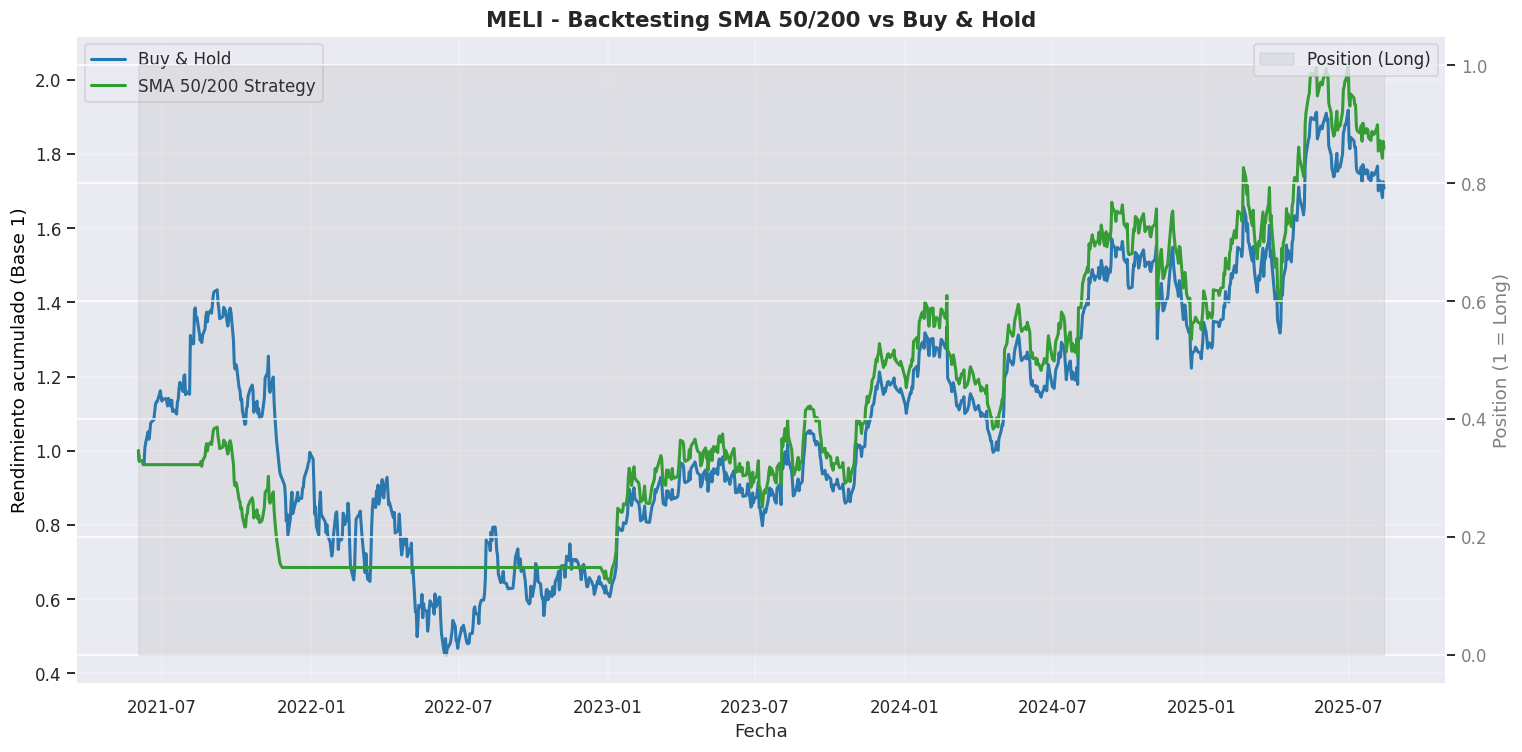


— Drawdown Analysis —


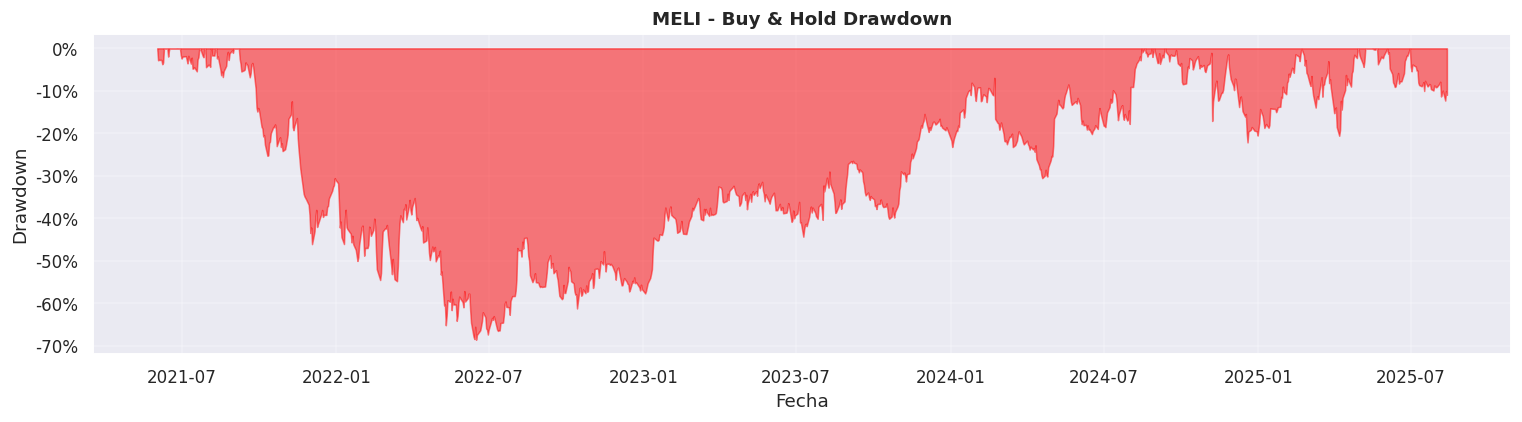

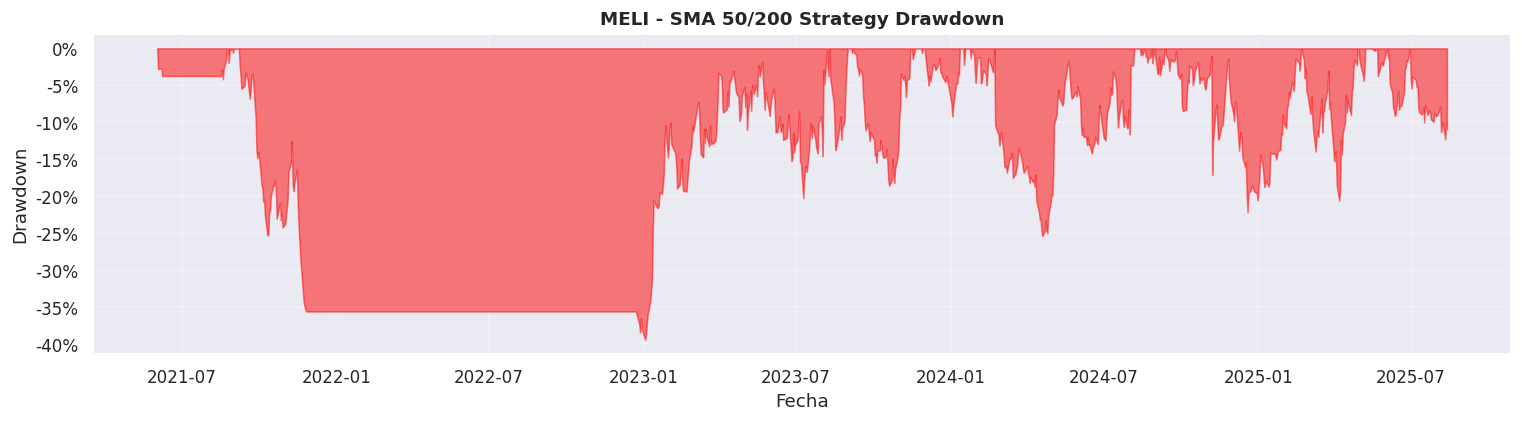

In [76]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  BLOQUE: Backtesting SMA 50/200 (versión ultra robusta MELI)        ║
# ╚══════════════════════════════════════════════════════════════════════╝
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, yfinance as yf, os, glob
from datetime import datetime, timedelta
sns.set_theme(style="darkgrid")

# -------------------- CONFIG --------------------
TICKER = "MELI"
FAST   = 50
SLOW   = 200
YEARS  = 5

# -------------------- EXTRACTORES --------------------
def _extract_close_from_df(df, ticker=None) -> pd.Series:
    """Devuelve Serie Close/Adj Close desde DF con columnas simples o MultiIndex."""
    if df is None or getattr(df, "empty", True):
        return pd.Series(dtype=float)

    # MultiIndex (ej: columnas tipo ('Close','MELI') o ('MELI','Close'))
    if isinstance(df.columns, pd.MultiIndex):
        # Caso nivel -1 contiene 'Close' o 'Adj Close'
        for lvl_name in ("Close", "Adj Close"):
            if lvl_name in df.columns.get_level_values(-1):
                tmp = df.xs(lvl_name, axis=1, level=-1)
                if isinstance(tmp, pd.DataFrame):
                    if ticker and ticker in tmp.columns:
                        s = tmp[ticker]
                    else:
                        s = tmp.iloc[:, 0]
                    return s.astype(float)
        # Intento alterno: buscar columnas cuyo nombre contenga el ticker
        cols = [c for c in df.columns if isinstance(c, tuple) and any(ticker in str(x) for x in c)]
        if cols:
            try:
                s = df[cols[0]].astype(float).squeeze()
                if isinstance(s, pd.DataFrame):  # si quedó 2D, tomar primera col
                    s = s.iloc[:,0]
                return s
            except:
                pass

    # Columnas simples
    for col in ("Close", "Adj Close", ticker):
        if col in df.columns:
            s = df[col].astype(float)
            return s

    # Último intento: columna cuyo nombre contenga el ticker
    for col in df.columns:
        if ticker in str(col):
            s = df[col].astype(float)
            return s

    return pd.Series(dtype=float)

# -------------------- CARGA DE SERIE CLOSE --------------------
def _load_close_series(ticker: str, years: int = 5) -> pd.Series:
    """Intenta: yfinance (varias formas) -> prices_df global -> CSV local."""
    end = datetime.now()
    start = end - timedelta(days=365*years)

    # 1) yfinance: varios intentos
    attempts = [
        dict(start=start, end=end, auto_adjust=True, progress=False),
        dict(period="5y", auto_adjust=True, progress=False),
        dict(period="10y", auto_adjust=True, progress=False),
        dict(period="max", auto_adjust=True, progress=False),
        dict(start=start, end=end, auto_adjust=False, progress=False),
        dict(period="5y", auto_adjust=False, progress=False),
        dict(period="1y", auto_adjust=True, progress=False),   # último recurso (alcanza para SMA200)
    ]
    for params in attempts:
        try:
            df = yf.download(ticker, **params)
            s  = _extract_close_from_df(df, ticker=ticker)
            if not s.empty:
                s.index = pd.to_datetime(s.index).tz_localize(None, nonexistent='shift_forward', ambiguous='NaT')
                s = s.sort_index()
                s.name = "Close"
                print(f"✓ Serie obtenida via yfinance con params: {params}")
                return s
        except Exception as e:
            # seguimos probando
            pass

    # 2) DataFrame global: prices_df
    if "prices_df" in globals():
        try:
            s = _extract_close_from_df(globals()["prices_df"], ticker=ticker)
            if not s.empty:
                s.index = pd.to_datetime(s.index).tz_localize(None, nonexistent='shift_forward', ambiguous='NaT')
                s = s.sort_index()
                s.name = "Close"
                print("✓ Serie tomada de prices_df en memoria.")
                return s
        except Exception:
            pass

    # 3) CSVs locales (intenta patrones comunes)
    candidates = []
    candidates += glob.glob("./*.csv")
    candidates += glob.glob("./**/*.csv", recursive=True)
    # Orden simple: los más recientes primero
    candidates = sorted(candidates, key=lambda p: os.path.getmtime(p), reverse=True)

    for path in candidates:
        try:
            df = pd.read_csv(path, index_col=0)
            # Index a datetime si luce como fecha
            try:
                df.index = pd.to_datetime(df.index)
            except Exception:
                pass
            s = _extract_close_from_df(df, ticker=ticker)
            if s.empty and ticker in df.columns:
                s = df[ticker].astype(float)
            if not s.empty:
                s.index = pd.to_datetime(s.index).tz_localize(None, nonexistent='shift_forward', ambiguous='NaT')
                s = s.sort_index()
                s.name = "Close"
                print(f"✓ Serie tomada de CSV local: {os.path.basename(path)}")
                return s
        except Exception:
            continue

    # si nada funcionó
    return pd.Series(dtype=float)

# -------------------- BACKTEST SMA --------------------
def _compute_sma_backtest(close: pd.Series, fast=50, slow=200):
    """Backtest LONG-only SMA fast/slow. Devuelve bh_eq, str_eq, position."""
    if not isinstance(close, pd.Series) or close.empty:
        raise ValueError("No hay datos de precios para backtest.")

    df = close.to_frame("Close").copy()
    df["SMA_fast"] = df["Close"].rolling(fast, min_periods=fast).mean()
    df["SMA_slow"] = df["Close"].rolling(slow, min_periods=slow).mean()
    df = df.dropna()
    if df.empty:
        raise ValueError("Serie muy corta para calcular SMA (aumentá el período o reducí SLOW).")

    position  = (df["SMA_fast"] > df["SMA_slow"]).astype(int)
    ret       = df["Close"].pct_change().fillna(0.0)
    strat_ret = (position.shift(1).fillna(0) * ret)

    bh_eq  = (1 + ret).cumprod().rename("Buy&Hold")
    str_eq = (1 + strat_ret).cumprod().rename("Strategy")
    return bh_eq, str_eq, position

def _plot_drawdown(cum_curve: pd.Series, title: str):
    peak = cum_curve.cummax()
    dd   = (cum_curve - peak) / peak
    plt.figure(figsize=(14,4))
    plt.fill_between(dd.index, dd.values, 0, color='red', alpha=0.5)
    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel('Fecha'); plt.ylabel('Drawdown')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y,_: f"{y:.0%}"))
    plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# -------------------- CARGA / RECÁLCULO SEGURO --------------------
bh_eq  = globals().get("bh_eq", None)
str_eq = globals().get("str_eq", None)
pos    = globals().get("position", None)

def _ok(s):
    return isinstance(s, pd.Series) and not s.empty and isinstance(s.index, pd.DatetimeIndex)

needs_recalc = not (_ok(bh_eq) and _ok(str_eq) and _ok(pos))

if needs_recalc:
    print(f"↻ No encontré resultados previos. Recalculando rápido para {TICKER}…")
    close = _load_close_series(TICKER, years=YEARS)
    if close.empty:
        raise ValueError("Serie de precios inválida o vacía (no se pudo obtener MELI por ninguna vía).")
    # Si la serie es corta para SMA200, prueba extender a 10y como último recurso
    if len(close) < SLOW + 5:
        print("⚠️ Serie corta para SMA200. Intentando 10y…")
        close_10y = _load_close_series(TICKER, years=10)
        if not close_10y.empty and len(close_10y) > len(close):
            close = close_10y
    bh_eq, str_eq, pos = _compute_sma_backtest(close, fast=FAST, slow=SLOW)
    print("✓ Backtest listo.")

# Alinear por seguridad
idx = bh_eq.index.intersection(str_eq.index).intersection(pos.index)
bh_eq  = bh_eq.reindex(idx)
str_eq = str_eq.reindex(idx)
pos    = pos.reindex(idx).fillna(0).astype(int)

# -------------------- GRÁFICOS --------------------
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.plot(bh_eq.index,  bh_eq.values,  label='Buy & Hold',          color='tab:blue',  lw=2)
ax1.plot(str_eq.index, str_eq.values, label='SMA 50/200 Strategy', color='tab:green', lw=2)
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Rendimiento acumulado (Base 1)', color='black')
ax1.set_title(f'{TICKER} - Backtesting SMA {FAST}/{SLOW} vs Buy & Hold', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left'); ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.fill_between(idx, 0, pos.values, where=pos.values==1, color='gray', alpha=0.12, label='Position (Long)')
ax2.set_ylabel('Position (1 = Long)', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')
ax2.set_ylim(-0.05, 1.05)
ax2.legend(loc='upper right')

plt.tight_layout(); plt.show()

print("\n— Drawdown Analysis —")
_ = _plot_drawdown(bh_eq,  f'{TICKER} - Buy & Hold Drawdown')
_ = _plot_drawdown(str_eq, f'{TICKER} - SMA {FAST}/{SLOW} Strategy Drawdown')

# Exponer para celdas futuras
globals().update({"bh_eq": bh_eq, "str_eq": str_eq, "position": pos, "TICKER": TICKER})



## 6. Análisis Fundamental (cont.)

### Análisis FODA (SWOT Analysis)

Basado en la investigación cualitativa y los datos financieros, se presenta un análisis de Fortalezas (Strengths), Oportunidades (Opportunities), Debilidades (Weaknesses) y Amenazas (Threats) para la empresa asignada (MELI) y en comparación con sus pares.

**Fortalezas (Strengths):**
*   **Posición dominante en LatAm:** Líder en e-commerce y fintech en mercados clave (Brasil, Argentina, México).
*   **Ecosistema integrado:** Sinergia entre Marketplace (MELI), Pagos (MP) y Logística (MELI Envios) genera eficiencia y retención.
*   **Alto crecimiento histórico:** Track record de expansión de ingresos y base de usuarios.
*   **Marca fuerte y reconocimiento:** Alta confianza del consumidor en la región.

**Oportunidades (Opportunities):**
*   **Penetración del e-commerce y pagos digitales en LatAm:** Aún hay gran potencial de crecimiento en la región.
*   **Expansión a nuevos servicios:** Crédito, seguros, wealth management para potenciar el ecosistema fintech.
*   **Internacionalización limitada fuera de LatAm:** Potencial a futuro, aunque no es foco principal.
*   **Adopción de nuevas tecnologías:** IA para personalización, eficiencia logística y detección de fraude.

**Debilidades (Weaknesses):**
*   **Exposición a riesgos macro de LatAm:** Volatilidad cambiaria, inflación, inestabilidad política.
*   **Dependencia de infraestructura logística externa:** Aunque MELI Envios crece, la calidad varía por región.
*   **Márgenes operativos aún por debajo de líderes globales:** Necesidad de escalar y optimizar costos.
*   **Competencia creciente:** Nuevos players locales e internacionales, bancos tradicionales digitalizándose.

**Amenazas (Threats):**
*   **Riesgo regulatorio:** Cambios en leyes fiscales, laborales, de protección al consumidor o fintech en múltiples países.
*   **Recesión o desaceleración económica en LatAm:** Impacto directo en el consumo discrecional.
*   **Inflación alta y persistente:** Afecta el poder de compra y los costos operativos.
*   **Disrupción tecnológica:** Nuevos modelos de negocio o tecnologías que desplacen su oferta.
*   **Competencia de precios:** Guerra de precios para ganar market share puede erosionar márgenes.

Current price of MELI: $2327.30

— Projected Free Cash Flows (Simplified Example) —


,FCF
Year,
1,"$625,000,000"
2,"$781,250,000"
3,"$976,562,500"
4,"$1,123,046,875"
5,"$1,291,503,906"
6,"$1,485,229,492"
7,"$1,708,013,916"
8,"$1,964,216,003"
9,"$2,258,848,404"



Shares Outstanding (MELI): 50,697,400

— DCF Valuation Results —
  PV of Forecasted FCFs: $7,291,833,480
  PV of Terminal Value:  $9,571,927,806
  Enterprise Value:      $16,863,761,286
  Equity Value:          $15,863,761,286

  Intrinsic Value per Share (MELI): $312.91
  Current Price: $2,327.30
  Potential Upside/Downside: -86.55%

— Sensitivity Analysis (Intrinsic Value per Share) —


Terminal Growth,0.020000,0.025000,0.030000,0.035000,0.040000
WACC,,,,,
0.100000,$392.06,$410.17,$430.87,$454.75,$482.60
0.105000,$362.49,$377.83,$395.21,$415.08,$438.00
0.110000,$336.36,$349.46,$364.19,$380.88,$399.95
0.115000,$313.14,$324.39,$336.97,$351.11,$367.14
0.120000,$292.38,$302.11,$312.91,$324.99,$338.57
0.125000,$273.72,$282.17,$291.52,$301.90,$313.50
0.130000,$256.87,$264.26,$272.38,$281.36,$291.33
0.135000,$241.60,$248.08,$255.17,$262.98,$271.61
0.140000,$227.69,$233.40,$239.63,$246.45,$253.95


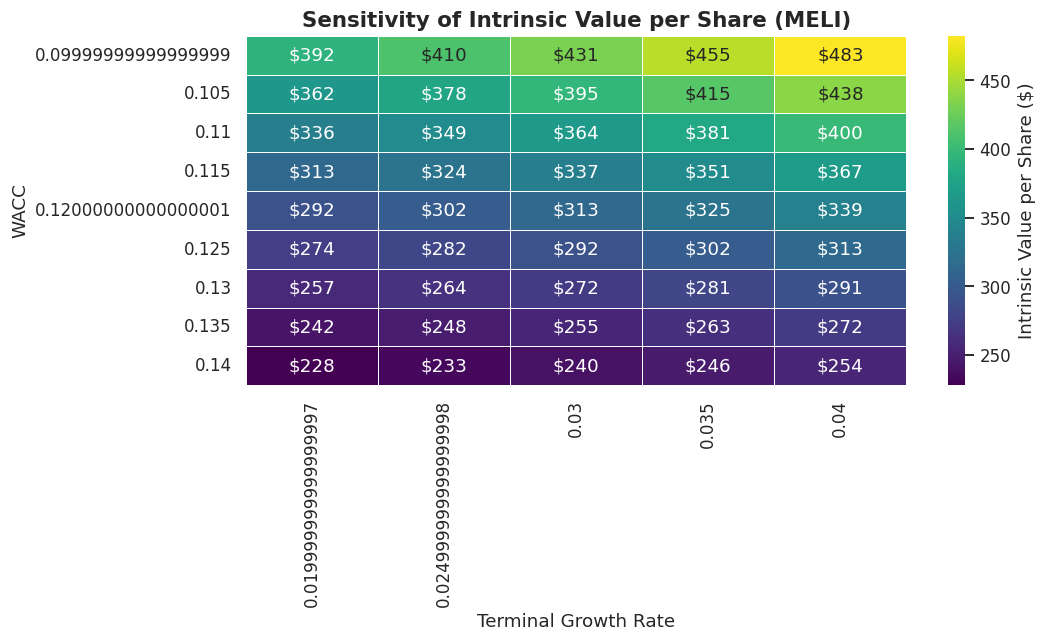


✅ DCF and Sensitivity Analysis complete.


In [77]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  BLOQUE: Análisis Fundamental (DCF con Sensibilidad)                 ║
# ╚══════════════════════════════════════════════════════════════════════║
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from matplotlib.ticker import StrMethodFormatter

sns.set_theme(style="whitegrid")

# --- Seguridad: Recrear tickers_fundamental if not available ---
try:
    tickers_fundamental
except NameError:
    ASIGNADA     = "MELI"
    COMPARABLES  = ["AMZN", "BABA", "SHOP", "NU"]
    BENCHMARKS   = ["SPY"]
    ALL_TICKERS  = [ASIGNADA] + COMPARABLES + BENCHMARKS
    tickers_fundamental = [t for t in ALL_TICKERS if t != "SPY"]

TARGET_TICKER = "MELI" # Empresa para el DCF
# Fetch the current price to compare with DCF value
try:
    current_price = yf.Ticker(TARGET_TICKER).history(period="1d")['Close'].iloc[-1]
    print(f"Current price of {TARGET_TICKER}: ${current_price:.2f}")
except Exception as e:
    current_price = None
    print(f"Could not fetch current price for {TARGET_TICKER}: {e}")


# --- DCF Parameters (Editable) ---
FORECAST_YEARS = 10        # Años de proyección explícita
TERMINAL_GROWTH_RATE = 0.03 # Tasa de crecimiento a perpetuidad (largo plazo)
WACC = 0.12                # Costo Promedio Ponderado de Capital (ajustar a riesgo)

# --- Financial Data (Simplified Example - REPLACE with actual projections) ---
# These numbers should come from financial analysis, analyst reports, or company guidance.
# This is a SIMPLIFIED EXAMPLE for illustration.
# Replace with your own research and projections.
# Example: Assuming MELI's Revenue and FCF Margin evolve over time
# You would typically forecast Revenue, Expenses, CapEx, Working Capital Changes
# to arrive at Free Cash Flow to Firm (FCFF)

# --- Placeholder: Replace with your detailed FCF projections ---
# Example: Starting FCF and assumed growth rates
initial_fcf = 500e6 # Example: $500 Million FCF in Year 0 (adjust based on latest data)
fcf_growth_high = 0.25 # Example: High growth in early years
fcf_growth_mid = 0.15  # Example: Mid growth in later forecast years

# Generate a simplified FCF projection (REPLACE this with your model)
fcf_projections = [initial_fcf]
for i in range(1, FORECAST_YEARS + 1):
    if i <= 3: # High growth for first 3 years
        next_fcf = fcf_projections[-1] * (1 + fcf_growth_high)
    else: # Mid growth for remaining forecast years
         next_fcf = fcf_projections[-1] * (1 + fcf_growth_mid)
    fcf_projections.append(next_fcf)

# Convert to DataFrame for easier handling
fcf_df = pd.DataFrame({
    'Year': range(FORECAST_YEARS + 1),
    'FCF': fcf_projections
})
# Drop Year 0 as it's the starting point, not a future cash flow
fcf_df = fcf_df[fcf_df['Year'] > 0].set_index('Year')

print("\n— Projected Free Cash Flows (Simplified Example) —")
display(fcf_df.style.format({'FCF': '${:,.0f}'}).set_caption("Tabla 3 – Proyecciones de FCF (Millones USD)"))


# --- DCF Calculation ---
def calculate_dcf(fcf_series: pd.Series, wacc: float, terminal_growth_rate: float) -> tuple:
    """Calculates PV of forecast FCFs, Terminal Value, and Total Enterprise Value."""
    if fcf_series.empty:
        return np.nan, np.nan, np.nan

    years = fcf_series.index.values
    discount_factors = 1 / ((1 + wacc)**years)

    # Present Value of Forecasted FCFs
    pv_fcfs = (fcf_series * discount_factors).sum()

    # Terminal Value Calculation (using Gordon Growth Model)
    last_fcf = fcf_series.iloc[-1]
    last_year = fcf_series.index[-1]

    if wacc <= terminal_growth_rate:
        print("Warning: WACC must be greater than Terminal Growth Rate for Gordon Growth Model.")
        terminal_value_at_last_year = np.nan
    else:
        terminal_value_at_last_year = last_fcf * (1 + terminal_growth_rate) / (wacc - terminal_growth_rate)

    # Present Value of Terminal Value
    pv_terminal_value = terminal_value_at_last_year / ((1 + wacc)**last_year)

    # Total Enterprise Value
    enterprise_value = pv_fcfs + pv_terminal_value

    return pv_fcfs, pv_terminal_value, enterprise_value

pv_fcfs, pv_terminal_value, enterprise_value = calculate_dcf(fcf_df['FCF'], WACC, TERMINAL_GROWTH_RATE)

# --- From Enterprise Value to Equity Value to Intrinsic Value per Share ---
# This step requires additional data from financial statements (Debt, Cash, Shares Outstanding)
# Replace these placeholders with actual data for the target ticker

# --- Placeholder: REPLACE with actual balance sheet data for TARGET_TICKER ---
total_debt = 4e9   # Example: $4 Billion (fetch from financial statements)
cash_equivalents = 3e9 # Example: $3 Billion (fetch from financial statements)
minority_interest = 0 # Example: $0 (fetch from financial statements)

# Placeholder: REPLACE with actual shares outstanding for TARGET_TICKER
try:
    shares_outstanding = yf.Ticker(TARGET_TICKER).info.get('sharesOutstanding', None)
    if shares_outstanding is None:
         raise ValueError("Could not fetch shares outstanding from yfinance.")
    print(f"\nShares Outstanding ({TARGET_TICKER}): {shares_outstanding:,.0f}")
except Exception as e:
    shares_outstanding = 1e9 # Example: 1 Billion shares (REPLACE)
    print(f"\nWarning: Could not fetch shares outstanding for {TARGET_TICKER}. Using placeholder {shares_outstanding:,.0f}. Error: {e}")


# Equity Value = Enterprise Value + Cash & Equivalents - Total Debt - Minority Interest
equity_value = enterprise_value + cash_equivalents - total_debt - minority_interest

# Intrinsic Value per Share
intrinsic_value_per_share = equity_value / shares_outstanding if shares_outstanding > 0 else np.nan

print("\n— DCF Valuation Results —")
print(f"  PV of Forecasted FCFs: ${pv_fcfs:,.0f}")
print(f"  PV of Terminal Value:  ${pv_terminal_value:,.0f}")
print(f"  Enterprise Value:      ${enterprise_value:,.0f}")
print(f"  Equity Value:          ${equity_value:,.0f}")
if intrinsic_value_per_share is not np.nan:
    print(f"\n  Intrinsic Value per Share ({TARGET_TICKER}): ${intrinsic_value_per_share:,.2f}")

if current_price is not None and intrinsic_value_per_share is not np.nan:
     upside_downside = (intrinsic_value_per_share / current_price) - 1
     print(f"  Current Price: ${current_price:,.2f}")
     print(f"  Potential Upside/Downside: {upside_downside:.2%}")


# --- Sensitivity Analysis (Optional) ---
print("\n— Sensitivity Analysis (Intrinsic Value per Share) —")

wacc_range = np.arange(WACC - 0.02, WACC + 0.021, 0.005) # +/- 2% around base WACC
g_range = np.arange(TERMINAL_GROWTH_RATE - 0.01, TERMINAL_GROWTH_RATE + 0.011, 0.005) # +/- 1% around base growth

sensitivity_results = pd.DataFrame(index=pd.Index(wacc_range, name='WACC'), columns=pd.Index(g_range, name='Terminal Growth'))

for w in wacc_range:
    for g in g_range:
        # Recalculate PV of Terminal Value for each scenario
        if w <= g:
             sensitivity_results.loc[w, g] = np.nan # Gordon Growth Model is invalid
        else:
            # Calculate Terminal Value at last year for this growth rate
            last_fcf = fcf_df['FCF'].iloc[-1]
            last_year = fcf_df.index[-1]
            tv_at_last_year = last_fcf * (1 + g) / (w - g)
            pv_tv = tv_at_last_year / ((1 + w)**last_year)
            # Total Enterprise Value for this scenario
            # Recalculate PV of FCFs with the new WACC
            discount_factors_scenario = 1 / ((1 + w)**fcf_df.index.values)
            pv_fcfs_scenario = (fcf_df['FCF'] * discount_factors_scenario).sum()

            enterprise_value_scenario = pv_fcfs_scenario + pv_tv

            # Equity Value and Intrinsic Value per Share for this scenario
            equity_value_scenario = enterprise_value_scenario + cash_equivalents - total_debt - minority_interest
            intrinsic_value_scenario = equity_value_scenario / shares_outstanding if shares_outstanding > 0 else np.nan

            sensitivity_results.loc[w, g] = intrinsic_value_scenario

# Display Sensitivity Table
display(sensitivity_results.style.format('${:,.2f}').set_caption(f"Tabla 4 – Sensibilidad del Valor Intrínseco ({TARGET_TICKER}) a WACC y Tasa Terminal"))

# --- Plot Sensitivity (Optional) ---
if not sensitivity_results.isnull().all().all():
    fig, ax = plt.subplots(figsize=(10, 6))
    # --- HEATMAP DE SENSIBILIDAD DCF (limpio, con $ en celdas y colorbar) ---
    # Asegurate de que la matriz base sea numérica
    mat = sensitivity_results.astype(float)

    # Etiquetas con $ para cada celda
    annot_labels = mat.applymap(lambda v: f"${v:,.0f}" if pd.notna(v) else "")

    sns.heatmap(
        mat,
        annot=annot_labels,      # usamos strings con $ como anotaciones
        fmt="",                  # fmt vacío porque las anotaciones ya están formateadas
        cmap="viridis",
        linewidths=.5,
        cbar_kws={'label': 'Intrinsic Value per Share ($)'},
        ax=ax
    )

    ax.set_title(f"Sensitivity of Intrinsic Value per Share ({TARGET_TICKER})",
                 fontsize=14, fontweight='bold')
    ax.set_xlabel("Terminal Growth Rate")
    ax.set_ylabel("WACC")

    # Formatear la barra de color con símbolo $
    cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
    cbar.update_ticks()

    plt.tight_layout()
    plt.show()


print("\n✅ DCF and Sensitivity Analysis complete.")

→ Métricas base (reglas estándar):
  Estrategia: Ret 152.27% | Vol 40.66% | Sharpe 0.97 | MDD -25.39%
  Buy&Hold : Ret 114.96% | Vol 41.33% | Sharpe 0.83 | MDD -30.09%
→ Optimizando parámetros…
✓ Hecho. Sharpe optimizado: 1.03
  Parámetros óptimos → MACD(9,20,5) · RSI(22) OB 76.1 · OS 24.4 · ADX>23.4


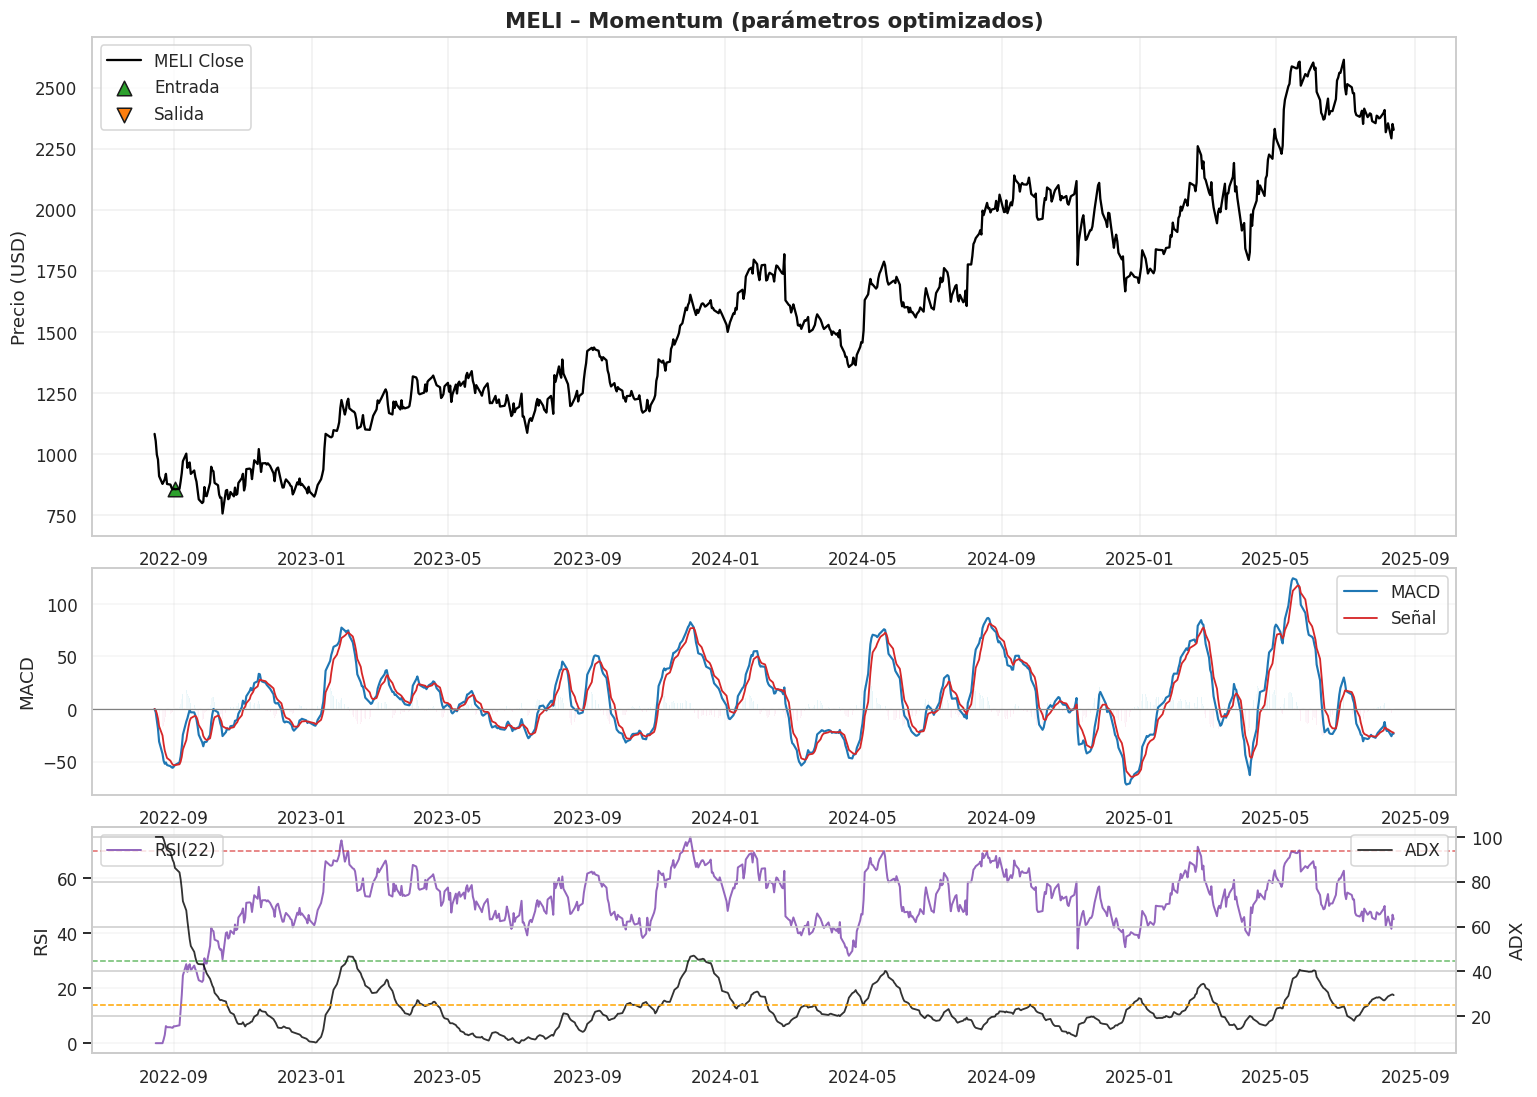

,Estrategia base,Optimizada,Buy&Hold
Ret. total,+152.30%,+171.90%,+115.00%
Vol. anual,0.41,0.41,0.41
Sharpe,0.97,1.03,0.83
Max DD,-25.40%,-25.40%,-30.10%


In [78]:
# ╔══════════════════════════════════════════════════════════════════╗
# ║  PASO 2 · Indicadores de Momentum – MELI (fix 1D Series)        ║
# ╚══════════════════════════════════════════════════════════════════╝
import yfinance as yf
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import differential_evolution
import warnings; warnings.filterwarnings("ignore")

TICKER = "MELI"
END    = datetime.now()
START  = END - timedelta(days=3*365)
plt.rcParams["figure.figsize"] = (16, 10)

# ---------- Utilidades seguras para extraer Series 1D ----------
def get_series(df: pd.DataFrame, key: str):
    """Devuelve una Series 1D (float) para la columna `key`, manejando MultiIndex o DataFrame (n,1)."""
    if isinstance(df.columns, pd.MultiIndex):
        # ¿existe la columna en el primer nivel?
        if key in df.columns.get_level_values(0):
            s = df[key]
            # si es DataFrame (n,1), convertir a Series
            if isinstance(s, pd.DataFrame):
                s = s.iloc[:, 0]
        else:
            return None
    else:
        if key in df.columns:
            s = df[key]
        else:
            return None
    return s.astype("float64").squeeze()

def get_close_priority(df: pd.DataFrame):
    """Intenta Close → Adj Close → primera columna como fallback, siempre 1D."""
    s = get_series(df, "Close")
    if s is None:
        s = get_series(df, "Adj Close")
    if s is None:
        # fallback: primera columna cualquiera
        first = df.iloc[:, 0]
        s = first.astype("float64").squeeze()
    return s

# ---------- Descarga de datos ----------
raw = yf.download(TICKER, start=START, end=END, auto_adjust=True, progress=False)
if raw.empty:
    raise ValueError("No se pudieron descargar datos.")

close = get_close_priority(raw)
high  = get_series(raw, "High")
low   = get_series(raw, "Low")

# si High/Low faltan (pasa con algunos ajustes), usar close como fallback
if high is None: high = close.copy()
if low  is None: low  = close.copy()

# ---------- Indicadores ----------
def macd(series, fast=12, slow=26, signal=9):
    ema_f = series.ewm(span=fast, adjust=False).mean()
    ema_s = series.ewm(span=slow, adjust=False).mean()
    line  = ema_f - ema_s
    sig   = line.ewm(span=signal, adjust=False).mean()
    hist  = line - sig
    return line, sig, hist

def rsi(series, period=14):
    d  = series.diff()
    up = d.clip(lower=0).ewm(alpha=1/period, adjust=False).mean()
    dn = (-d.clip(upper=0)).ewm(alpha=1/period, adjust=False).mean()
    rs = up / dn
    return 100 - (100/(1+rs))

def adx_plus_minus(high, low, close, period=14):
    tr  = pd.concat([(high-low).abs(),
                     (high-close.shift()).abs(),
                     (low -close.shift()).abs()], axis=1).max(axis=1)
    atr = tr.ewm(alpha=1/period, adjust=False).mean()
    up_move   = high.diff()
    down_move = -low.diff()
    plus_dm  = np.where((up_move>down_move) & (up_move>0),  up_move,  0.0)
    minus_dm = np.where((down_move>up_move) & (down_move>0), down_move, 0.0)
    plus_di  = 100 * pd.Series(plus_dm, index=high.index).ewm(alpha=1/period, adjust=False).mean() / atr
    minus_di = 100 * pd.Series(minus_dm, index=low.index ).ewm(alpha=1/period, adjust=False).mean() / atr
    dx  = 100 * (plus_di - minus_di).abs() / (plus_di + minus_di).replace(0, np.nan)
    adx = dx.ewm(alpha=1/period, adjust=False).mean()
    return adx, plus_di, minus_di

macd_line, macd_sig, macd_hist = macd(close)
rsi14 = rsi(close, 14)
adx14, plus_di, minus_di = adx_plus_minus(high, low, close, 14)

# ---------- Señales base + backtest ----------
signal_long = ((macd_line > macd_sig) & (adx14 > 25) & (rsi14 < 70)).astype(int)
position    = signal_long.replace(0, np.nan).ffill().fillna(0)
ret         = close.pct_change().fillna(0)
strat_ret   = (position.shift(1)*ret).fillna(0)
bh_ret      = ret

def max_dd(curve):
    run_max = curve.cummax()
    return (curve/run_max - 1).min()

strat_curve = (1+strat_ret).cumprod()
bh_curve    = (1+bh_ret).cumprod()

ann_vol_s   = strat_ret.std()*np.sqrt(252); ann_vol_bh = bh_ret.std()*np.sqrt(252)
sharpe_s    = (strat_ret.mean()*252)/ann_vol_s if ann_vol_s>0 else np.nan
sharpe_bh   = (bh_ret.mean()*252)/ann_vol_bh   if ann_vol_bh>0 else np.nan

print("→ Métricas base (reglas estándar):")
print(f"  Estrategia: Ret {strat_curve.iloc[-1]-1:,.2%} | Vol {ann_vol_s:,.2%} | Sharpe {sharpe_s:,.2f} | MDD {max_dd(strat_curve):.2%}")
print(f"  Buy&Hold : Ret {bh_curve.iloc[-1]-1:,.2%} | Vol {ann_vol_bh:,.2%} | Sharpe {sharpe_bh:,.2f} | MDD {max_dd(bh_curve):.2%}")

# ---------- Optimización ligera (Sharpe máx) ----------
bounds = [(8,20),(20,40),(5,15),(10,25),(65,85),(20,35),(15,35)]  # f,s,g,rp,RSI OB, RSI OS, ADX TH

def eval_params(p):
    f,s,g, rp, r_ob, r_os, a_th = p
    f,s,g,rp = map(int,[f,s,g,rp])
    if f>=s or r_os>=r_ob: return 1e6
    m_line, m_sig, _ = macd(close, f,s,g)
    r  = rsi(close, rp)
    a,_,_ = adx_plus_minus(high, low, close, 14)
    sig = ((m_line>m_sig) & (a>a_th) & (r<r_ob)).astype(int)
    pos = sig.replace(0,np.nan).ffill().fillna(0)
    r_d = (pos.shift(1)*ret).fillna(0)
    vol = r_d.std()*np.sqrt(252)
    if vol==0 or np.isnan(vol): return 1e6
    return -(r_d.mean()*252/vol)

print("→ Optimizando parámetros…")
opt = differential_evolution(eval_params, bounds=bounds, maxiter=25, seed=42, polish=True)
f,s,g, rp, r_ob, r_os, a_th = opt.x
f,s,g,rp = map(int,[f,s,g,rp])

m_line_o, m_sig_o, m_hist_o = macd(close, f,s,g)
rsi_o = rsi(close, rp)
adx_o,_,_ = adx_plus_minus(high, low, close, 14)
sig_o = ((m_line_o>m_sig_o) & (adx_o>a_th) & (rsi_o<r_ob)).astype(int)
pos_o = sig_o.replace(0,np.nan).ffill().fillna(0)
ret_o = (pos_o.shift(1)*ret).fillna(0)
curve_o = (1+ret_o).cumprod()
vol_o   = ret_o.std()*np.sqrt(252)
shp_o   = (ret_o.mean()*252/vol_o) if vol_o>0 else np.nan

print(f"✓ Hecho. Sharpe optimizado: {shp_o:,.2f}")
print(f"  Parámetros óptimos → MACD({f},{s},{g}) · RSI({rp}) OB {r_ob:.1f} · OS {r_os:.1f} · ADX>{a_th:.1f}")

# ---------- Gráficos ----------
fig = plt.figure(figsize=(16,12)); gs = fig.add_gridspec(3,1, height_ratios=[2.2,1,1], hspace=0.10)
ax1 = fig.add_subplot(gs[0,0])
ax1.plot(close.index, close, color="black", lw=1.5, label=f"{TICKER} Close")
ent = pos_o.diff().fillna(0)==1; sal = pos_o.diff().fillna(0)==-1
ax1.scatter(close.index[ent], close[ent], marker="^", s=90, color="#2ca02c", edgecolor="k", label="Entrada")
ax1.scatter(close.index[sal], close[sal], marker="v", s=90, color="#ff7f0e", edgecolor="k", label="Salida")
ax1.set_title(f"{TICKER} – Momentum (parámetros optimizados)", fontsize=14, fontweight="bold")
ax1.set_ylabel("Precio (USD)"); ax1.legend(loc="upper left"); ax1.grid(alpha=.3)

ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
ax2.plot(m_line_o.index, m_line_o, label="MACD", color="#1f77b4", lw=1.4)
ax2.plot(m_sig_o.index,  m_sig_o,  label="Señal", color="#d62728", lw=1.2)
ax2.bar(m_hist_o.index,  m_hist_o, color=np.where(m_hist_o>=0,"#9edae5","#f7b6d2"), alpha=.6)
ax2.axhline(0, color="gray", lw=0.8); ax2.set_ylabel("MACD"); ax2.legend(); ax2.grid(alpha=.2)

ax3 = fig.add_subplot(gs[2,0], sharex=ax1)
ax3.plot(rsi_o.index, rsi_o, color="#9467bd", lw=1.3, label=f"RSI({rp})")
ax3.axhline(70, color="#d62728", ls="--", lw=1, alpha=.7); ax3.axhline(30, color="#2ca02c", ls="--", lw=1, alpha=.7)
ax3_t = ax3.twinx()
ax3_t.plot(adx_o.index, adx_o, color="black", lw=1.2, alpha=.8, label="ADX"); ax3_t.axhline(25, color="orange", ls="--", lw=1)
ax3.set_ylabel("RSI"); ax3_t.set_ylabel("ADX"); ax3.legend(loc="upper left"); ax3_t.legend(loc="upper right"); ax3.grid(alpha=.2)
plt.tight_layout(); plt.show()

# ---------- Tabla resumen ----------
def max_dd_curve(c):
    m = c.cummax(); return (c/m - 1).min()

summary = pd.DataFrame({
    "Estrategia base":[strat_curve.iloc[-1]-1, ann_vol_s, sharpe_s, max_dd_curve(strat_curve)],
    "Optimizada":[curve_o.iloc[-1]-1, vol_o, shp_o, max_dd_curve(curve_o)],
    "Buy&Hold":[bh_curve.iloc[-1]-1, ann_vol_bh, sharpe_bh, max_dd_curve(bh_curve)]
}, index=["Ret. total","Vol. anual","Sharpe","Max DD"]).round(3)

try:
    display(summary.style.format({
        "Estrategia base":"{:+.2%}", "Optimizada":"{:+.2%}", "Buy&Hold":"{:+.2%}"
    }, subset=pd.IndexSlice[["Ret. total","Max DD"], :]).format({
        "Estrategia base":"{:.2f}", "Optimizada":"{:.2f}", "Buy&Hold":"{:.2f}"
    }, subset=pd.IndexSlice[["Vol. anual","Sharpe"], :]).set_caption("Indicadores de Momentum – MELI"))
except:
    print(summary)


Ticker: MELI | Ventana: 2022-08-15 → 2025-08-14
Parámetros Bollinger: SMA 20, 2σ
• % cierres fuera de bandas: arriba 5.46 % | abajo 4.64 % | total 10.10 %
• Señales por cruce (últimos 3 años): compras=16 | ventas=22
• Estado actual: SQUEEZE (ancho en el decil inferior reciente)


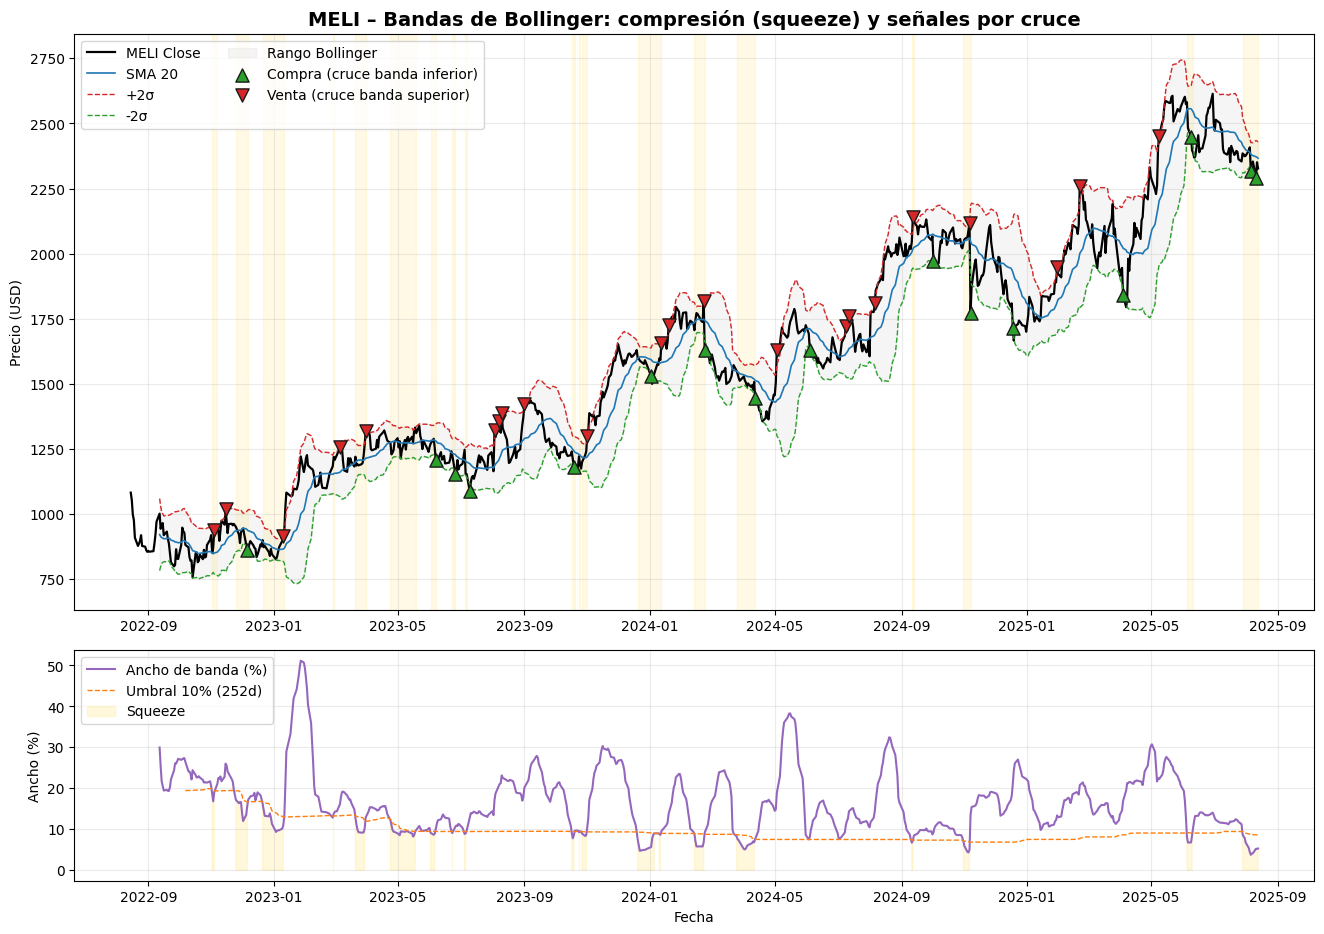

,Señal,Fecha,Precio
0,Compra,2024-12-18,"$1,716.38"
1,Compra,2025-04-04,"$1,841.29"
2,Compra,2025-06-09,"$2,448.60"
3,Compra,2025-08-06,"$2,317.22"
4,Compra,2025-08-11,"$2,292.04"
5,Venta,2024-09-12,"$2,140.10"
6,Venta,2024-11-06,"$2,117.30"
7,Venta,2025-01-30,"$1,947.32"
8,Venta,2025-02-21,"$2,260.00"
9,Venta,2025-05-09,"$2,450.00"


In [79]:
# ╔══════════════════════════════════════════════════════════════════╗
# ║  PASO 3 · Análisis de Volatilidad – Bandas de Bollinger (MELI)  ║
# ╚══════════════════════════════════════════════════════════════════╝
import yfinance as yf
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings; warnings.filterwarnings("ignore")

# ---------- Parámetros ----------
TICKER = "MELI"
END    = datetime.now()
START  = END - timedelta(days=3*365)   # 3 años para volatilidad
WIN    = 20
NSTD   = 2

plt.rcParams["figure.figsize"] = (16, 10)
plt.style.use("default")

# ---------- Utilidad robusta para extraer Series 1D ----------
def _safe_series(df: pd.DataFrame, col: str):
    if isinstance(df.columns, pd.MultiIndex):
        if col in df.columns.get_level_values(0):
            s = df[col]
            if isinstance(s, pd.DataFrame):  # (n,1) → Series
                s = s.iloc[:, 0]
        else:
            return None
    else:
        s = df[col] if col in df.columns else None
    return None if s is None else s.astype("float64").squeeze()

def _get_close(df: pd.DataFrame):
    s = _safe_series(df, "Close")
    if s is None:
        s = _safe_series(df, "Adj Close")
    if s is None:  # último recurso: primera columna
        s = df.iloc[:, 0].astype("float64").squeeze()
    return s

# ---------- Descarga y preparación ----------
raw = yf.download(TICKER, start=START, end=END, auto_adjust=True, progress=False)
if raw.empty:
    raise ValueError("No se pudieron descargar datos.")
close = _get_close(raw)
mid   = close.rolling(WIN).mean()
std   = close.rolling(WIN).std()
up    = mid + NSTD*std
lo    = mid - NSTD*std

# Indicadores de banda
width = (up - lo) / mid * 100.0               # ancho relativo (%)
pctB  = (close - lo) / (up - lo)              # %B de Bollinger

# ---------- Señales ----------
# Señal por "cruce" (evita multiplicidad de días consecutivos)
buy_cross  = (close.shift(1) > lo.shift(1)) & (close <= lo)     # toque/ruptura banda inferior
sell_cross = (close.shift(1) < up.shift(1)) & (close >= up)     # toque/ruptura banda superior
buy_idx    = close.index[buy_cross.fillna(False)]
sell_idx   = close.index[sell_cross.fillna(False)]

# % de tiempo fuera de bandas (sobre universo válido)
valid = (~up.isna()) & (~lo.isna())
pct_above = ( (close > up) & valid ).sum() / valid.sum() * 100
pct_below = ( (close < lo) & valid ).sum() / valid.sum() * 100

# Squeeze: ancho en el decil inferior de los últimos 252 días
thr_10 = width.rolling(252, min_periods=WIN).quantile(0.10)
squeeze = (width <= thr_10)

# ---------- Prints resumen ----------
last = close.index[-1]
print(f"Ticker: {TICKER} | Ventana: {START.strftime('%Y-%m-%d')} → {END.strftime('%Y-%m-%d')}")
print(f"Parámetros Bollinger: SMA {WIN}, {NSTD}σ")
print(f"• % cierres fuera de bandas: arriba {pct_above:.2f} % | abajo {pct_below:.2f} % | total {(pct_above+pct_below):.2f} %")
print(f"• Señales por cruce (últimos 3 años): compras={buy_cross.sum()} | ventas={sell_cross.sum()}")
if squeeze.iloc[-1]:
    print("• Estado actual: SQUEEZE (ancho en el decil inferior reciente)")
else:
    print("• Estado actual: Normal/Expansión")

# ---------- Gráficos ----------
fig = plt.figure(figsize=(16, 11))
gs  = fig.add_gridspec(2, 1, height_ratios=[3,1.2], hspace=0.10)

# Panel 1: Precio + Bandas + Señales
ax1 = fig.add_subplot(gs[0,0])
ax1.plot(close.index, close, color="black", lw=1.6, label=f"{TICKER} Close")
ax1.plot(mid.index,   mid,   color="#1f77b4", lw=1.2, label=f"SMA {WIN}")
ax1.plot(up.index,    up,    color="#d62728", lw=1.0, ls="--", label="+{:.0f}σ".format(NSTD))
ax1.plot(lo.index,    lo,    color="#2ca02c", lw=1.0, ls="--", label="-{:.0f}σ".format(NSTD))
ax1.fill_between(close.index, lo, up, color="#bdbdbd", alpha=.15, label="Rango Bollinger")

# Señales en el gráfico
if len(buy_idx)>0:
    ax1.scatter(buy_idx, close.loc[buy_idx], marker="^", s=90, color="#2ca02c", edgecolor="k", label="Compra (cruce banda inferior)", zorder=5)
if len(sell_idx)>0:
    ax1.scatter(sell_idx, close.loc[sell_idx], marker="v", s=90, color="#d62728", edgecolor="k", label="Venta (cruce banda superior)", zorder=5)

# Sombras suaves para períodos de squeeze (tramos recientes, para no saturar)
in_block = False; start_blk = None
for dt, is_sq in squeeze.fillna(False).items():
    if is_sq and not in_block:
        in_block = True; start_blk = dt
    if not is_sq and in_block:
        ax1.axvspan(start_blk, dt, color="#ffdd57", alpha=.15)
        in_block = False
# si termina en squeeze, cerrar
if in_block:
    ax1.axvspan(start_blk, squeeze.index[-1], color="#ffdd57", alpha=.15)

ax1.set_title(f"{TICKER} – Bandas de Bollinger: compresión (squeeze) y señales por cruce",
              fontsize=14, fontweight="bold")
ax1.set_ylabel("Precio (USD)")
ax1.legend(loc="upper left", ncol=2, frameon=True)
ax1.grid(alpha=.25)

# Panel 2: Ancho de banda y umbral 10% (squeeze)
ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
ax2.plot(width.index, width, color="#9467bd", lw=1.5, label="Ancho de banda (%)")
ax2.plot(thr_10.index, thr_10, color="#ff7f0e", lw=1.0, ls="--", label="Umbral 10% (252d)")
ax2.fill_between(width.index, 0, width, where=squeeze.fillna(False), color="#ffdd57", alpha=.2, label="Squeeze")
ax2.set_ylabel("Ancho (%)")
ax2.set_xlabel("Fecha")
ax2.legend(loc="upper left", frameon=True)
ax2.grid(alpha=.25)

plt.tight_layout()
plt.show()

# ---------- Tabla breve de señales recientes ----------
events = []
for idx in buy_idx[-5:]:
    events.append(["Compra", idx.strftime("%Y-%m-%d"), float(close.loc[idx])])
for idx in sell_idx[-5:]:
    events.append(["Venta", idx.strftime("%Y-%m-%d"), float(close.loc[idx])])

if events:
    tbl = pd.DataFrame(events, columns=["Señal","Fecha","Precio"])
    display(tbl.style.set_caption("Señales recientes por cruce de bandas").format({"Precio":"${:,.2f}"}))
else:
    print("No hay señales recientes para mostrar.")


📊 MÉTRICAS – Estrategia integral vs. Buy & Hold (MELI)


,Estrategia,Buy & Hold
Retorno total,35.78%,95.59%
Volatilidad anual,48.14%,50.78%
Sharpe Ratio,0.37,0.52
Max Drawdown,-68.64%,-69.12%
Calmar Ratio,0.09,0.21
Win Rate,100.00%,N/A


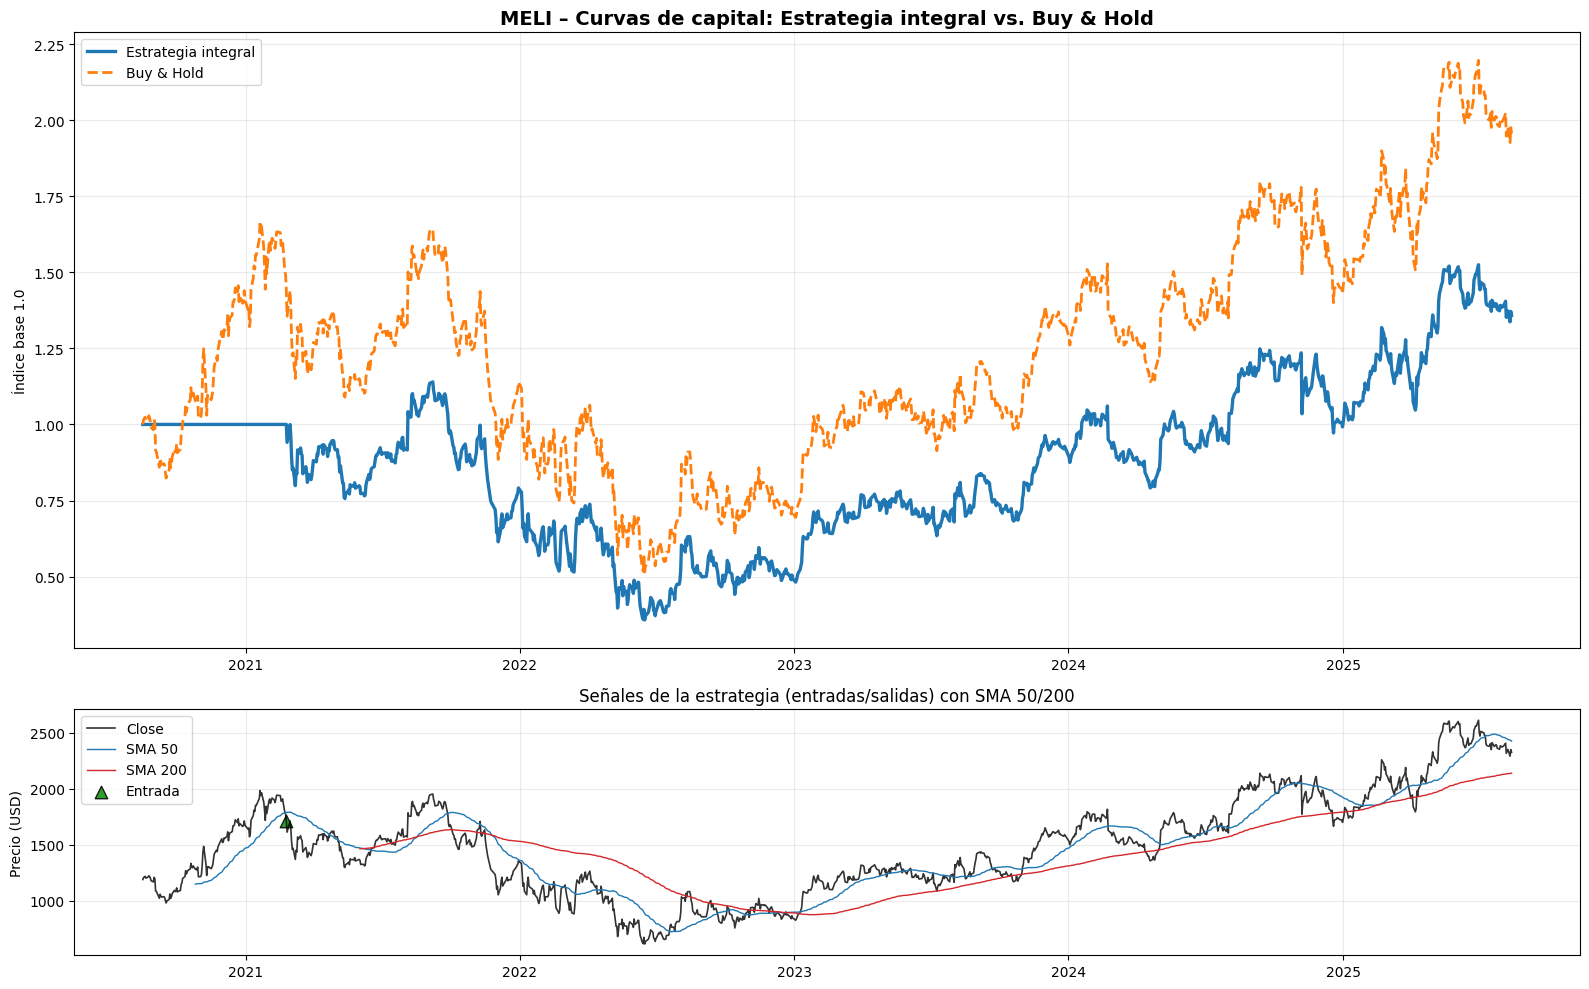

In [80]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  PASO 4 · Estrategia integral (MELI) + Backtesting y métricas       ║
# ╚══════════════════════════════════════════════════════════════════════╝
import yfinance as yf
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings; warnings.filterwarnings("ignore")

# -------- Parámetros generales --------
TICKER = "MELI"
END    = datetime.now()
START  = END - timedelta(days=5*365)      # 5 años para robustez
rf     = 0.0                               # tasa libre para Sharpe (simplificado)
plt.rcParams["figure.figsize"] = (16, 10)
plt.style.use("default")

# -------- Utilidades robustas --------
def _safe_series(df: pd.DataFrame, col: str):
    if isinstance(df.columns, pd.MultiIndex):
        if col in df.columns.get_level_values(0):
            s = df[col]
            if isinstance(s, pd.DataFrame):
                s = s.iloc[:, 0]
            return s.astype("float64").squeeze()
        else:
            return None
    else:
        if col in df.columns:
            s = df[col]
            if isinstance(s, pd.DataFrame):
                s = s.squeeze()
            return s.astype("float64")
        else:
            return None

def _get_ohlc(df: pd.DataFrame):
    """Devuelve (close, high, low) como Series 1D, compatible con DataFrame
    normal o con MultiIndex de yfinance. Maneja casos donde las columnas no existen."""

    # 1) Close: preferir 'Adj Close' if exists; otherwise 'Close'
    close = _safe_series(df, "Adj Close")
    if close is None:
        close = _safe_series(df, "Close")

    # Fallback if neither 'Adj Close' nor 'Close' is found
    if close is None:
        if not df.empty:
             # Try to use the first column as a last resort
            close = df.iloc[:, 0].astype(float).squeeze()
            print("Warning: Using the first column as 'Close' price.")
        else:
            raise ValueError("DataFrame is empty and could not find 'Close' or 'Adj Close' column.")

    # 2) High / Low (if missing, clone close for robustness)
    high = _safe_series(df, "High")
    if high is None:
        high = close.copy()
        if not df.empty and "High" not in df.columns:
             print("Warning: 'High' column not found. Using 'Close' for High prices.")


    low = _safe_series(df, "Low")
    if low is None:
        low = close.copy()
        if not df.empty and "Low" not in df.columns:
            print("Warning: 'Low' column not found. Using 'Close' for Low prices.")


    # Align indices and ensure 1D type
    close.index = pd.to_datetime(close.index)
    high = high.reindex(close.index).astype(float)
    low  = low.reindex(close.index).astype(float)

    return close, high, low


def macd(price, fast=12, slow=26, signal=9):
    ema_fast = price.ewm(span=fast, adjust=False).mean()
    ema_slow = price.ewm(span=slow, adjust=False).mean()
    line = ema_fast - ema_slow
    sig  = line.ewm(span=signal, adjust=False).mean()
    hist = line - sig
    return line, sig, hist

def rsi(price, period=14):
    delta = price.diff()
    gain  = delta.clip(lower=0).ewm(span=period, adjust=False).mean()
    loss  = (-delta.clip(upper=0)).ewm(span=period, adjust=False).mean()
    rs    = gain / loss.replace(0, np.nan)
    return 100 - (100 / (1 + rs))

def adx_plus_minus(high, low, close, period=14):
    up_move   = high.diff()
    down_move = -low.diff()
    plus_dm  = np.where((up_move > down_move) & (up_move > 0), up_move, 0.0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0.0)
    plus_dm  = pd.Series(plus_dm, index=high.index)
    minus_dm = pd.Series(minus_dm, index=high.index)

    tr1 = (high - low)
    tr2 = (high - close.shift(1)).abs()
    tr3 = (low  - close.shift(1)).abs()
    tr  = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    atr = tr.ewm(alpha=1/period, adjust=False).mean()
    pdi = 100 * (plus_dm.ewm(alpha=1/period, adjust=False).mean() / atr)
    mdi = 100 * (minus_dm.ewm(alpha=1/period, adjust=False).mean() / atr)
    dx  = 100 * ( (pdi - mdi).abs() / (pdi + mdi).replace(0, np.nan) )
    adx = dx.ewm(alpha=1/period, adjust=False).mean()
    return adx, pdi, mdi

def max_drawdown(equity):
    peak = equity.cummax()
    dd   = equity/peak - 1.0
    return dd.min()

def annualized_return(equity, periods_per_year=252):
    n = len(equity)
    if n < 2: return np.nan
    total = equity.iloc[-1] / equity.iloc[0] - 1
    cagr  = (equity.iloc[-1])**(periods_per_year/n) - 1
    return max(-1.0, cagr)

# -------- Descarga de datos --------
raw = yf.download(TICKER, start=START, end=END, auto_adjust=True, progress=False)
if raw.empty:
    raise ValueError("No data downloaded.")

close, high, low = _get_ohlc(raw)


# -------- Indicadores base --------
sma50  = close.rolling(50).mean()
sma200 = close.rolling(200).mean()
macd_line, macd_sig, macd_hist = macd(close)
rsi14  = rsi(close, 14)
adx14, plus_di, minus_di = adx_plus_minus(high, low, close, 14)

# Bollinger (para detectar sobrecompra/sobreventa y timing de salida)
mid = close.rolling(20).mean()
std = close.rolling(20).std()
up  = mid + 2*std
lo  = mid - 2*std

# -------- Reglas de la estrategia (coherente y simple) --------
# Tendencia: filtro principal
trend_up = sma50 > sma200

# Momentum: confirmación
mom_up = macd_line > macd_sig

# Fuerza de tendencia (evita operar en ruido; umbral suave)
trend_strength = adx14 >= 18

# Reversión táctica: permite entrar tras “lavada” fuerte
reversion_long = close <= lo

# Entrada LARGA si (tendencia alcista y momentum y fortaleza) o (reversión en banda inferior)
entry_long = (trend_up & mom_up & trend_strength) | reversion_long

# Salidas:
# 1) giro de tendencia
exit_by_trend = sma50 < sma200
# 2) momentum se deteriora y RSI sobrecompra → tomar ganancias
exit_by_mom_rsi = (macd_line < macd_sig) & (rsi14 >= 65)
# 3) toque de banda superior → parcial/total
exit_by_band = close >= up

# Posición (long-only): 1 si dentro, 0 si fuera
position = pd.Series(0, index=close.index, dtype=int)
position[entry_long] = 1
# cortar cuando se activa alguna salida
position[(exit_by_trend | exit_by_mom_rsi | exit_by_band)] = 0
# mantener estado (forward-fill)
position = position.replace(0, np.nan).ffill().fillna(0).astype(int)

# -------- Backtesting --------
ret_d = close.pct_change().fillna(0)
strat_ret_d = (position.shift(1).fillna(0) * ret_d)

# Curvas de capital
bh_equity    = (1 + ret_d).cumprod()
strat_equity = (1 + strat_ret_d).cumprod()

# Métricas
ann_mu_bh    = ret_d.mean()*252
ann_vol_bh   = ret_d.std()*np.sqrt(252)
sharpe_bh    = (ann_mu_bh - rf) / ann_vol_bh if ann_vol_bh>0 else np.nan
dd_bh        = max_drawdown(bh_equity)
cagr_bh      = annualized_return(bh_equity)
calmar_bh    = (cagr_bh/abs(dd_bh)) if (dd_bh<0 and pd.notna(cagr_bh)) else np.nan

ann_mu_s     = strat_ret_d.mean()*252
ann_vol_s    = strat_ret_d.std()*np.sqrt(252)
sharpe_s     = (ann_mu_s - rf) / ann_vol_s if ann_vol_s>0 else np.nan
dd_s         = max_drawdown(strat_equity)
cagr_s       = annualized_return(strat_equity)
calmar_s     = (cagr_s/abs(dd_s)) if (dd_s<0 and pd.notna(cagr_s)) else np.nan

# Win Rate por trade (entrada→salida)
# Detectar cambios 0→1 (entrada) y 1→0 (salida)
pos_chg = position.diff().fillna(0)
entries = close.index[pos_chg==1]
exits   = close.index[pos_chg==-1]

# Emparejar en orden
trades = []
ei = 0; xi = 0
while ei < len(entries):
    ent = entries[ei]
    # salida posterior a la entrada; si no hay, usamos el último día
    sal = exits[exits > ent]
    sal = sal[0] if len(sal)>0 else close.index[-1]
    ret_trade = close.loc[sal] / close.loc[ent] - 1.0
    trades.append(ret_trade)
    # avanzar al siguiente exit usado
    ei += 1
    exits = exits[exits > sal]

trades = pd.Series(trades, name="TradeReturn")
win_rate = (trades > 0).mean() if len(trades)>0 else np.nan

# -------- Reporte de métricas --------
res = pd.DataFrame({
    "Estrategia":[
        f"{(strat_equity.iloc[-1]-1):.2%}",
        f"{ann_vol_s:.2%}",
        f"{sharpe_s:.2f}",
        f"{dd_s:.2%}",
        f"{calmar_s:.2f}" if pd.notna(calmar_s) else "N/A",
        f"{win_rate:.2%}" if pd.notna(win_rate) else "N/A"
    ],
    "Buy & Hold":[
        f"{(bh_equity.iloc[-1]-1):.2%}",
        f"{ann_vol_bh:.2%}",
        f"{sharpe_bh:.2f}",
        f"{dd_bh:.2%}",
        f"{calmar_bh:.2f}" if pd.notna(calmar_bh) else "N/A",
        "N/A"
    ]
}, index=["Retorno total","Volatilidad anual","Sharpe Ratio","Max Drawdown","Calmar Ratio","Win Rate"])

print("📊 MÉTRICAS – Estrategia integral vs. Buy & Hold (MELI)")
display(res)

# -------- Gráficos --------
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,10), gridspec_kw={"height_ratios":[3,1.2]})
# Curva de capital
ax1.plot(strat_equity.index, strat_equity, label="Estrategia integral", lw=2.4)
ax1.plot(bh_equity.index,    bh_equity,    label="Buy & Hold",        lw=2.0, ls="--")
ax1.set_title(f"{TICKER} – Curvas de capital: Estrategia integral vs. Buy & Hold", fontsize=14, weight="bold")
ax1.set_ylabel("Índice base 1.0")
ax1.grid(alpha=.25); ax1.legend(loc="upper left")

# Señales (entradas y salidas) sobre el precio
ax2.plot(close.index, close, color="black", lw=1.2, alpha=.8, label="Close")
ax2.plot(close.index, sma50, color="#1f77b4", lw=1.0, label="SMA 50")
ax2.plot(close.index, sma200,color="#d62728", lw=1.0, label="SMA 200")
ent_idx = close.index[pos_chg==1]
sal_idx = close.index[pos_chg==-1]
if len(ent_idx)>0:
    ax2.scatter(ent_idx, close.loc[ent_idx], marker="^", s=80, color="#2ca02c", edgecolor="k", label="Entrada")
if len(sal_idx)>0:
    ax2.scatter(sal_idx, close.loc[sal_idx], marker="v", s=80, color="#ff7f0e", edgecolor="k", label="Salida")
ax2.set_title("Señales de la estrategia (entradas/salidas) con SMA 50/200", fontsize=12)
ax2.set_ylabel("Precio (USD)"); ax2.grid(alpha=.25); ax2.legend(loc="upper left")

plt.tight_layout(); plt.show()


**Pregunta crítica**— ¿Por qué el análisis técnico podría ser más o menos efectivo en Argentina?
En mercados locales la menor liquidez genera gaps y deslizamiento que “rompen” patrones; además, la
volatilidad macro y cambiaria provoca shocks discrecionales (regulatorios, cepos, resultados electorales)
que no están en los promedios históricos. Por eso, señales puramente técnicas suelen requerir marcos
temporal más amplios, filtros de tendencia (SMA 200), stops más holgados y tamaños de posición menores.
En mercados desarrollados (EE. UU.), la mayor profundidad y transparencia hacen que soportes/resistencias
y promedios móviles se respeten con más consistencia, mejorando la efectividad estadística de las reglas.

In [81]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  PARTE III · FUNDAMENTAL – Dashboard sectorial comparables (MELI)   ║
# ╚══════════════════════════════════════════════════════════════════════╝
import yfinance as yf
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 50)

# --- 1) Tickers comparables (evita ETFs para ratios) -------------------------
TICKERS_FUND = ["MELI", "AMZN", "BABA", "SHOP", "NU"]

# --- 2) Utilidades robustas --------------------------------------------------
def _safe(d, key, default=np.nan):
    """Devuelve d[key] si existe y no es None/0 (cuando no corresponde), si no NaN."""
    try:
        v = d.get(key, default)
        if v in [None, "None"]:
            return default
        return v
    except Exception:
        return default

def _pick_row_sum_ttm(df, label_like: str):
    """Suma TTM de una fila cuyo nombre 'contenga' label_like (case-insensitive)."""
    if not isinstance(df, pd.DataFrame) or df.empty:
        return np.nan
    # índices a lowercase
    idx_lc = {str(i).lower(): i for i in df.index}
    # buscar mejor match
    key = None
    for k in idx_lc:
        if label_like.lower() in k:
            key = idx_lc[k]; break
    if key is None:
        return np.nan
    # tomar últimos 4 períodos si es trimestral; si es anual, usar la última col
    vals = df.loc[key]
    if vals.shape[0] >= 4:
        return float(pd.to_numeric(vals.iloc[:4], errors="coerce").sum())
    return float(pd.to_numeric(vals.iloc[:1], errors="coerce").sum())

def interest_coverage_ttm(tk: yf.Ticker):
    """
    Cobertura de intereses ≈ Operating Income (TTM) / |Interest Expense (TTM)|.
    Fallback a anual si trimestral no está disponible.
    """
    # intentar trimestral
    for attr in ["quarterly_income_stmt", "quarterly_financials"]:
        q = getattr(tk, attr, pd.DataFrame())
        if isinstance(q, pd.DataFrame) and not q.empty:
            op = _pick_row_sum_ttm(q, "operating income")
            ie = _pick_row_sum_ttm(q, "interest expense")
            if not np.isnan(op) and not np.isnan(ie) and ie != 0:
                return op / abs(ie)
    # fallback anual
    for attr in ["income_stmt", "financials"]:
        a = getattr(tk, attr, pd.DataFrame())
        if isinstance(a, pd.DataFrame) and not a.empty:
            # usar la última columna anual
            def last_val(name):
                v = a.loc[[i for i in a.index if name in str(i).lower()]]
                if v.empty: return np.nan
                return float(pd.to_numeric(v.iloc[:, 0], errors="coerce").squeeze())
            op = last_val("operating income")
            ie = last_val("interest expense")
            if not np.isnan(op) and not np.isnan(ie) and ie != 0:
                return op / abs(ie)
    return np.nan

def ev_based_ratios(info: dict, tk: yf.Ticker):
    """
    Calcula EV/EBITDA y EV/Revenue con fallbacks TTM si faltan en .info
    """
    ev     = _safe(info, "enterpriseValue")
    ebitda = _safe(info, "ebitda")
    sales  = _safe(info, "totalRevenue")

    # Fallback TTM con quarterly_financials si falta revenue o ebitda
    if (np.isnan(sales) or sales == 0) and hasattr(tk, "quarterly_financials"):
        qf = tk.quarterly_financials
        if isinstance(qf, pd.DataFrame) and not qf.empty:
            sales = _pick_row_sum_ttm(qf, "total revenue")

    # EBITDA TTM no siempre disponible -> intentar 'operating income' como proxy si falta
    if (np.isnan(ebitda) or ebitda == 0):
        q = getattr(tk, "quarterly_income_stmt", pd.DataFrame())
        if isinstance(q, pd.DataFrame) and not q.empty:
            ebitda = _pick_row_sum_ttm(q, "ebitda")
            if np.isnan(ebitda) or ebitda == 0:
                # proxy muy conservador
                ebitda = _pick_row_sum_ttm(q, "operating income")

    ev_ebitda = np.nan
    ev_sales  = np.nan
    try:
        if not np.isnan(ev) and not np.isnan(ebitda) and ebitda != 0:
            ev_ebitda = ev / ebitda
        if not np.isnan(ev) and not np.isnan(sales) and sales != 0:
            ev_sales = ev / sales
    except Exception:
        pass
    return ev_ebitda, ev_sales

def debt_to_equity(info: dict, tk: yf.Ticker):
    """
    Devuelve Deuda/Patrimonio (%) usando .info si está; sino balance sheet.
    """
    d2e = _safe(info, "debtToEquity")
    if not np.isnan(d2e):
        return d2e  # yfinance ya suele traer porcentual

    # Fallback: totalDebt / totalStockholderEquity
    bs = getattr(tk, "balance_sheet", pd.DataFrame())
    if isinstance(bs, pd.DataFrame) and not bs.empty:
        def pick(name):
            r = bs.loc[[i for i in bs.index if name in str(i).lower()]]
            if r.empty: return np.nan
            return float(pd.to_numeric(r.iloc[:, 0], errors="coerce").squeeze())
        total_debt = pick("total debt")
        equity     = pick("total stockholder equity")
        if not np.isnan(total_debt) and not np.isnan(equity) and equity != 0:
            return (total_debt / equity) * 100.0
    return np.nan

# --- 3) Recolección de datos -------------------------------------------------
rows = []
errors = []
for t in TICKERS_FUND:
    try:
        tk = yf.Ticker(t)
        info = tk.info  # puede demorar; es lo más práctico para un dashboard rápido

        ev_ebitda, ev_rev = ev_based_ratios(info, tk)
        icov = interest_coverage_ttm(tk)
        d2e  = debt_to_equity(info, tk)

        row = {
            "Ticker": t,

            # Valuación
            "EV/EBITDA (x)": ev_ebitda,
            "EV/Ventas (x)": ev_rev,
            "Fwd P/E (x)":   _safe(info, "forwardPE"),
            "Trai P/E (x)":  _safe(info, "trailingPE"),
            "PEG (x)":       _safe(info, "pegRatio"),
            "P/B (x)":       _safe(info, "priceToBook"),
            "P/S (x)":       _safe(info, "priceToSalesTrailing12Months"),

            # Rentabilidad
            "Margen Oper.":  _safe(info, "operatingMargins") * 100 if not np.isnan(_safe(info, "operatingMargins")) else np.nan,
            "Margen Neto":   _safe(info, "profitMargins") * 100   if not np.isnan(_safe(info, "profitMargins")) else np.nan,
            "ROA":           _safe(info, "returnOnAssets") * 100  if not np.isnan(_safe(info, "returnOnAssets")) else np.nan,
            "ROE":           _safe(info, "returnOnEquity") * 100  if not np.isnan(_safe(info, "returnOnEquity")) else np.nan,

            # Solvencia
            "Deuda/Equity (%)": d2e,
            "Interest Coverage (x)": icov,

            # Mercado
            "Market Cap (Bn)": (_safe(info, "marketCap") / 1e9) if not np.isnan(_safe(info, "marketCap")) else np.nan,
            "52W High": _safe(info, "fiftyTwoWeekHigh"),
            "52W Low":  _safe(info, "fiftyTwoWeekLow"),
            "52W Change (%)": _safe(info, "52WeekChange") * 100 if not np.isnan(_safe(info, "52WeekChange")) else np.nan,
            "Beta": _safe(info, "beta"),
        }
        rows.append(row)
    except Exception as e:
        errors.append((t, str(e)))

dash = pd.DataFrame(rows).set_index("Ticker")

# --- 4) Formato de salida ----------------------------------------------------
fmt_pct = ["Margen Oper.", "Margen Neto", "ROA", "ROE", "Deuda/Equity (%)", "52W Change (%)"]
fmt_x   = ["EV/EBITDA (x)", "EV/Ventas (x)", "Fwd P/E (x)", "Trai P/E (x)", "PEG (x)", "P/B (x)", "P/S (x)", "Interest Coverage (x)", "Beta"]
fmt_num = ["Market Cap (Bn)", "52W High", "52W Low"]

styled = (dash
          .copy()
          .style
          .format({**{k:"{:.2f}x" for k in fmt_x},
                   **{k:"{:.1f}%" for k in fmt_pct},
                   **{"Market Cap (Bn)":"{:.0f} Bn", "52W High":"${:,.0f}", "52W Low":"${:,.0f}"}}
                  , na_rep="—")
          .background_gradient(cmap="RdYlGn_r", subset=["EV/EBITDA (x)","EV/Ventas (x)","Fwd P/E (x)","Trai P/E (x)","PEG (x)"])
          .set_caption("Dashboard sectorial – Cálculo propio con datos de Yahoo Finance (TTM cuando es posible)")
         )

display(styled)

# (opcional) guardar a CSV para el informe/anexo
dash.to_csv("dashboard_sectorial.csv", float_format="%.4f")
print("✓ Dashboard exportado a dashboard_sectorial.csv")
if errors:
    print("Notas:", errors[:2], "...")  # muestra un par de errores si hubo


,EV/EBITDA (x),EV/Ventas (x),Fwd P/E (x),Trai P/E (x),PEG (x),P/B (x),P/S (x),Margen Oper.,Margen Neto,ROA,ROE,Deuda/Equity (%),Interest Coverage (x),Market Cap (Bn),52W High,52W Low,52W Change (%),Beta
Ticker,,,,,,,,,,,,,,,,,,
MELI,33.75x,5.11x,48.10x,57.46x,—,20.65x,4.90x,12.1%,8.5%,7.0%,43.8%,157.7%,18.19x,118 Bn,"$2,645","$1,646",16.6%,1.46x
AMZN,18.39x,3.67x,36.51x,34.23x,—,7.17x,3.57x,11.4%,10.5%,7.7%,24.8%,47.8%,34.17x,2395 Bn,$243,$161,26.4%,1.31x
BABA,11.61x,2.26x,12.85x,17.01x,—,0.29x,0.30x,14.0%,13.1%,5.3%,11.4%,22.8%,14.68x,302 Bn,$148,$78,59.5%,0.16x
NU,398.90x,9.03x,19.95x,28.11x,—,6.93x,10.57x,57.7%,38.1%,4.4%,27.9%,—,0.04x,60 Bn,$16,$9,-10.2%,1.06x


✓ Dashboard exportado a dashboard_sectorial.csv
Notas: [('SHOP', "cannot convert the series to <class 'float'>")] ...


### 6.1 · Dashboard sectorial — metodología
Se construye una tabla comparativa para MELI y 4 comparables (AMZN, BABA, SHOP, NU) con ratios de valuación, rentabilidad, solvencia y mercado.
Los datos provienen de *yfinance* (`.info`) y, cuando faltan, se estima TTM con estados trimestrales (suma de 4 trimestres).
EV/EBITDA y EV/Ventas se calculan como `enterpriseValue / EBITDA` y `enterpriseValue / totalRevenue`.
La cobertura de intereses ≈ `Operating Income (TTM) / |Interest Expense (TTM)|`.
Se formatea la tabla con gradientes para facilitar lectura y se exporta a CSV.


## 6.2 · Análisis de Calidad y Riesgo

### FODA — Mercado Libre (MELI)
**Fortalezas**
- Ecosistema integrado (marketplace + pagos + logística + crédito) con efectos de red en dos lados.
- Marca líder en LatAm y densidad de usuarios/vendedores difícil de replicar.
- Escala logística (Fulfillment + última milla) que baja tiempos y costos de entrega.
- Monetización cruzada (Checkout, Wallet, Crédito, Seguros) que eleva el LTV por usuario.

**Debilidades**
- Apalancamiento financiero y costo de fondeo sensibles a tasas regionales.
- Exposición a monedas débiles (ARS/BRL/MXN): volatilidad en márgenes en USD.
- Dependencia de crecimiento LatAm; menor diversificación geográfica vs. mega-cap globales.
- Crédito al consumo/merchant: riesgo de incobrabilidad en ciclos débiles.

**Oportunidades**
- Bancarización de no bancarizados (pagos, tarjetas, préstamos, seguros, inversiones).
- Penetración de e-commerce aún baja vs. EEUU/Asia → “runway” de crecimiento.
- Eficiencias por IA/analítica (ruteo, prevención de fraude, underwriting de crédito).
- Alianzas omnicanal con retailers y expansión de soluciones para PyMEs.

**Amenazas**
- Regulación fintech (límites a comisiones, interchange, requisitos de capital).
- Entrada agresiva de players low-cost (Shein/Temu) y Big Tech en la región.
- Shocks macro/cambiarios en LatAm, con presión en consumo y funding.
- Riesgos cibernéticos y de fraude que erosionan confianza/engagement.

---

### Ventajas competitivas (moat)
1. **Efectos de red**: más vendedores → más surtido/precio → más compradores, y viceversa. Difícil de “arrancar de cero”.
2. **Economías de escala en logística**: costo unitario cae con volumen; barrera de entrada operacional.
3. **Datos propietarios**: señales de transacción/behavior que mejoran underwriting en Mercado Crédito y antifraude.
4. **Integración pagos–comercio**: checkout propio reduce fricción y eleva conversión (take-rate defendible).
5. **Marca y confianza**: preferencia del usuario/merchant reduce elasticidad ante ofertas de competidores.

---

### Riesgos específicos y mitigación
**Regulatorios**
- Topes a comisiones en Brasil/Argentina; cambios en reglas de crédito/solvencia.
- *Mitigación:* diversificar ingresos (advertising, logística), compliance proactivo y adaptación de pricing.

**Cambiarios (relevante para LatAm)**
- Devaluaciones (ARS/BRL/MXN) y controles de capital afectando FCF en USD.
- *Mitigación:* “natural hedge” (costos/ingresos locales), cash en USD, coberturas selectivas, pricing dinámico.

**Operativos**
- Incobrabilidad en crédito, fraudes, ciberataques, cuellos logísticos.
- *Mitigación:* scoring dinámico, límites de exposición, inversiones en ciberseguridad y redundancias operativas.

**De mercado/competencia**
- Presión de marketplaces asiáticos y Big Tech; sensibilidad a tasas altas (WACC↑ ⇒ múltiplos↓).
- *Mitigación:* foco en experiencia/entrega, bundle de servicios (fintech + logística), retención por ecosistema.

---

**¿Cómo impacta el contexto macro argentino en la valuación vs. competidores internacionales?**  
Argentina agrega una prima de riesgo país y volatilidad cambiaria que elevan el **WACC** y, por lo tanto, reducen el valor presente de los flujos (múltiplos más bajos a igualdad de crecimiento). La inflación alta y los controles de capital complican la **repatriación de efectivo** y generan ruido en métricas en USD. Además, shocks de demanda y tasas reales elevadas encarecen el **funding** del negocio crediticio. En conjunto, estos factores exigen **descuentos** y un margen de seguridad mayor que el de pares globales; aun así, el “moat” regional puede sostener una prima relativa frente a jugadores locales sin ecosistema comparable.

**Indicadores a monitorear (trimestral):** NPLs y cobertura en Mercado Crédito, take-rate y TPV de pagos, margen logístico/tiempos de entrega, FX mix y caja en USD, capex/FCF, evolución regulatoria en BR/AR.


In [82]:
import pandas as pd
from IPython.display import display

# ---- FODA en tabla resumida
foda = pd.DataFrame({
    "Fortalezas": [
        "Ecosistema integrado con efectos de red",
        "Escala logística y tiempos de entrega",
        "Datos para crédito/antifraude",
        "Checkout/pagos propios (conversión↑)"
    ],
    "Debilidades": [
        "Sensibilidad a tasas (apalancamiento)",
        "Exposición a monedas débiles (FX)",
        "Menor diversificación geográfica",
        "Riesgo de crédito en ciclos débiles"
    ],
    "Oportunidades": [
        "Bancarización y cross-selling fintech",
        "Penetración e-commerce aún baja",
        "IA para eficiencia/underwriting",
        "Retail omnicanal y soluciones PyME"
    ],
    "Amenazas": [
        "Regulación fintech/comisiones",
        "Competencia low-cost / Big Tech",
        "Shocks macro/cambiarios LatAm",
        "Ciber-riesgo / fraude"
    ]
})
display(foda)

# ---- Registro de riesgos con score (Probabilidad x Impacto)
riesgos = pd.DataFrame([
    ["Regulatorio", "Topes a comisiones / capital regulatorio", 3, 4, "Diversificar ingresos; diálogo regulatorio; pricing adaptativo", "Cambios normativos; resoluciones del BCB/BCRA"],
    ["Cambiario", "Devaluaciones y restricciones FX",            4, 4, "Natural hedge; caja USD; coberturas selectivas",             "Brecha cambiaria; reservas BCRA; CPI/IPP"],
    ["Operativo", "Incobrabilidad crédito / ciberataques",        3, 5, "Scoring dinámico; límites; inversión en ciberseguridad",     "NPLs; pérdidas por fraude; uptime sistemas"],
    ["Mercado",   "Competencia agresiva (Shein/Temu/BigTech)",    3, 3, "Diferenciación por servicio; bundle; lealtad de usuarios",   "Cuota de mercado; CAC/LTV; tiempos de entrega"]
], columns=["Tipo", "Riesgo", "Probabilidad(1-5)", "Impacto(1-5)", "Mitigación", "Indicadores"])

riesgos["Score"] = riesgos["Probabilidad(1-5)"] * riesgos["Impacto(1-5)"]
styled = (riesgos.style
          .background_gradient(cmap="Reds", subset=["Score"])
          .bar(subset=["Probabilidad(1-5)","Impacto(1-5)"], color="#f0b3b3")
          .set_caption("Registro de riesgos — probabilidad, impacto y mitigación"))
display(styled)


,Fortalezas,Debilidades,Oportunidades,Amenazas
0,Ecosistema integrado con efectos de red,Sensibilidad a tasas (apalancamiento),Bancarización y cross-selling fintech,Regulación fintech/comisiones
1,Escala logística y tiempos de entrega,Exposición a monedas débiles (FX),Penetración e-commerce aún baja,Competencia low-cost / Big Tech
2,Datos para crédito/antifraude,Menor diversificación geográfica,IA para eficiencia/underwriting,Shocks macro/cambiarios LatAm
3,Checkout/pagos propios (conversión↑),Riesgo de crédito en ciclos débiles,Retail omnicanal y soluciones PyME,Ciber-riesgo / fraude


,Tipo,Riesgo,Probabilidad(1-5),Impacto(1-5),Mitigación,Indicadores,Score
0,Regulatorio,Topes a comisiones / capital regulatorio,3,4,Diversificar ingresos; diálogo regulatorio; pricing adaptativo,Cambios normativos; resoluciones del BCB/BCRA,12
1,Cambiario,Devaluaciones y restricciones FX,4,4,Natural hedge; caja USD; coberturas selectivas,Brecha cambiaria; reservas BCRA; CPI/IPP,16
2,Operativo,Incobrabilidad crédito / ciberataques,3,5,Scoring dinámico; límites; inversión en ciberseguridad,NPLs; pérdidas por fraude; uptime sistemas,15
3,Mercado,Competencia agresiva (Shein/Temu/BigTech),3,3,Diferenciación por servicio; bundle; lealtad de usuarios,Cuota de mercado; CAC/LTV; tiempos de entrega,9


## 6.3 · Valuación y decisión de inversión (DCF simplificado)

**Objetivo.** Estimar un valor intrínseco por acción de *MELI* usando un DCF de una etapa alta (5 años) + valor terminal, y decidir **Comprar/Mantener/Vender** comparando contra el precio de mercado.

**Metodología.**
1) **Inputs operativos**: ingresos TTM, caja, deuda, acciones (desde Yahoo Finance).  
2) **Supuestos clave** (editables en el código):  
   - Margen FCF: 12 %  
   - Crec. FCF 5 años: 12 % anual  
   - Crec. a perpetuidad (g∞): 4 %  
3) **WACC**: se calcula con **CAPM** para el costo de equity (rf + β·ERP) y costo de deuda después de impuestos. Pesos por valor de mercado (E/V, D/V).  
4) **DCF**: FCF proyectado 5 años + **valor terminal** = Σ(FCF descontados) + VT descontado. Se resta **deuda neta** y se divide por acciones.  
5) **Sensibilidad**: mapa de calor **WACC × g∞** (con margen FCF fijo) y curva **Precio vs. margen FCF**.

**Regla de recomendación (heurística):**  
- **Comprar** si upside ≥ +20 %.  
- **Mantener** si está entre −10 % y +20 %.  
- **Vender/Reducir** si ≤ −10 %.  

> *Nota*: El DCF es sensible a supuestos (WACC, g∞, margen FCF). Interpretar junto a análisis de riesgo, técnico y comparables del sector.


— Inputs financieros (aprox) —
Precio USD:                     2,327.30
Ingresos TTM (USD):             24,096,000,000
Deuda total / Caja (USD):       9,009,999,872 / 3,983,000,064
Acciones en circulación:        50,697,400
Beta:                           1.46  |  Market Cap USD: 117,988,065,280

— WACC (detalle) —
rf=4.0%, ERP=5.0%, β=1.46 ⇒ Ke=11.31%
wd=7.1%, we=92.9%, Kd(pre)=8.0%, Tax=28.0% ⇒ WACC≈10.92%

— Supuestos DCF —
Margen FCF=12.0%, Crec. 5y=12.0%, g∞=4.0%, años=5

— Resultado base —
Valor intrínseco (USD):         1,094.85
Upside vs precio:               -53.0%
Recomendación heurística:       VENDER/REDUCIR


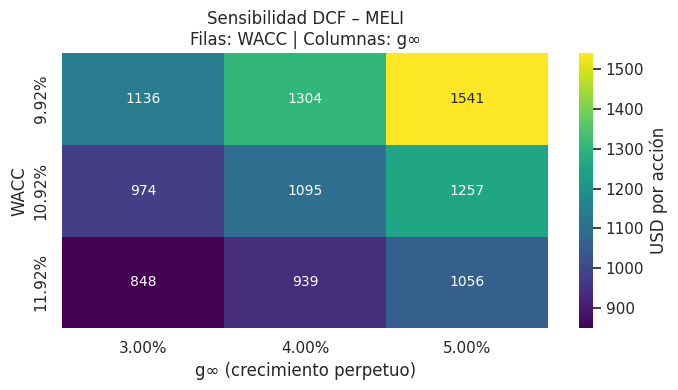

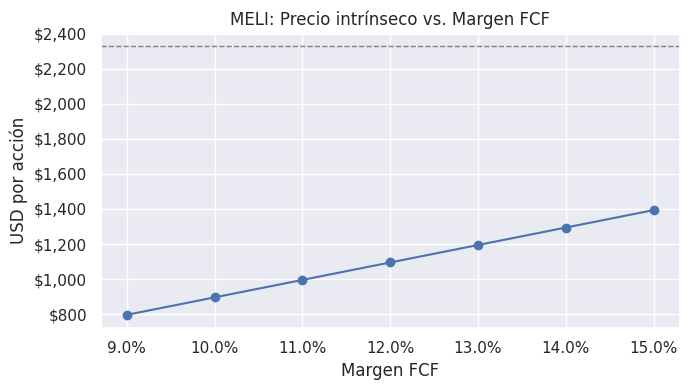

In [83]:
# ================================
# DCF simplificado para MELI
# ================================
import numpy as np, pandas as pd, yfinance as yf
import matplotlib.pyplot as plt, seaborn as sns
from matplotlib.ticker import FuncFormatter

sns.set_theme(style="darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

TICKER = "MELI"  # ← cambiá aquí si querés valorar otro ticker

# ------------------------------
# 1) Descarga de datos base
# ------------------------------
tk = yf.Ticker(TICKER)

# Precio spot (ajustado)
hist = tk.history(period="2y", auto_adjust=True)
if hist.empty:
    raise ValueError("No se pudieron descargar precios. Verifica el ticker/conexión.")
price = float(hist["Close"].iloc[-1])

# Info fundamental (con tolerancia a faltantes)
def _get_info_safe(tk):
    out = {}
    try:
        info = tk.info or {}
    except Exception:
        info = {}
    # Campos típicos (pueden venir vacíos en algunos tickers)
    out["totalRevenue"]      = info.get("totalRevenue", np.nan)
    out["totalDebt"]         = info.get("totalDebt", np.nan)
    out["totalCash"]         = info.get("totalCash", np.nan)
    out["sharesOutstanding"] = info.get("sharesOutstanding", np.nan)
    out["beta"]              = info.get("beta", np.nan)
    out["marketCap"]         = info.get("marketCap", np.nan)
    out["effectiveTaxRate"]  = info.get("effectiveTaxRate", np.nan)
    return out

raw = _get_info_safe(tk)

# Defaults razonables si falta algún dato
rev_ttm   = np.nan_to_num(raw["totalRevenue"],      nan=8.0e9)   # USD
debt_tot  = np.nan_to_num(raw["totalDebt"],         nan=3.0e9)
cash_tot  = np.nan_to_num(raw["totalCash"],         nan=4.0e9)
shares    = np.nan_to_num(raw["sharesOutstanding"], nan=max(int(np.nan_to_num(raw["marketCap"], nan=60e9)//price), 50_000_000))
beta      = np.nan_to_num(raw["beta"],              nan=1.4)
mktcap    = np.nan_to_num(raw["marketCap"],         nan=price*shares)
tax_eff   = np.nan_to_num(raw["effectiveTaxRate"],  nan=0.28)    # 28% por defecto

# ------------------------------
# 2) Supuestos (editables)
# ------------------------------
# CAPM / WACC
rf   = 0.04   # 4% tasa libre (aprox. UST a largo plazo)
erp  = 0.05   # 5% prima de mercado global
ke   = rf + beta*erp

# costo de deuda antes de impuestos (aprox) y WACC
kd_pre = 0.08
tax    = np.clip(tax_eff, 0.15, 0.35)  # acotar rango razonable 15%–35%

E = mktcap
D = debt_tot
V = max(E + D, 1.0)
we, wd = E/V, D/V
wacc_base = we*ke + wd*kd_pre*(1 - tax)

# Supuestos operativos DCF
fcf_margin = 0.12      # 12% del revenue TTM como FCF base
growth_5y  = 0.12      # 12% anual en 5 años
g_term     = 0.04      # 4% perpetuo
years      = 5

# ------------------------------
# 3) Función DCF
# ------------------------------
def dcf_value_per_share(revenue_ttm, fcf_margin, g5, g_term, wacc, years, debt, cash, shares):
    """
    DCF de etapa única (5 años) + perpetuidad. FCF0 = rev_TTM * fcf_margin.
    """
    fcf0 = revenue_ttm * fcf_margin
    # Proyección FCF (crece g5 los primeros 'years' años)
    fcfs = [(fcf0 * ((1 + g5) ** t)) for t in range(1, years+1)]
    disc = [(1 / ((1 + wacc) ** t)) for t in range(1, years+1)]
    pv_fcfs = sum(f*d for f, d in zip(fcfs, disc))
    # Valor terminal al año 'years'
    fcf_T = fcfs[-1] * (1 + g_term)
    tv = fcf_T / max(wacc - g_term, 1e-6)
    pv_tv = tv / ((1 + wacc) ** years)
    # EV y equity
    ev = pv_fcfs + pv_tv
    eq = ev - (debt - cash)
    return eq / max(shares, 1)

# ------------------------------
# 4) Cálculo base
# ------------------------------
wacc_use = float(np.clip(wacc_base, 0.07, 0.14))  # acotar 7%–14% por prudencia
intrinsic = dcf_value_per_share(
    rev_ttm, fcf_margin, growth_5y, g_term, wacc_use, years, debt_tot, cash_tot, shares
)

upside = (intrinsic/price - 1.0) * 100

# ------------------------------
# 5) Sensibilidades (WACC × g∞) y curva margen FCF
# ------------------------------
wacc_grid = np.array([wacc_use - 0.01, wacc_use, wacc_use + 0.01])
wacc_grid = np.clip(wacc_grid, 0.06, 0.16)
g_grid = np.array([g_term - 0.01, g_term, g_term + 0.01])
g_grid = np.clip(g_grid, 0.02, 0.06)

sens = pd.DataFrame(index=[f"{w:.2%}" for w in wacc_grid],
                    columns=[f"{g:.2%}" for g in g_grid], dtype=float)

for w in wacc_grid:
    for g in g_grid:
        val = dcf_value_per_share(rev_ttm, fcf_margin, growth_5y, g, w, years, debt_tot, cash_tot, shares)
        sens.loc[f"{w:.2%}", f"{g:.2%}"] = val

# Curva precio vs margen FCF (manteniendo WACC y g∞ base)
margins = np.linspace(max(fcf_margin-0.03, 0.06), fcf_margin+0.03, 7)
px_vs_margin = pd.Series({
    f"{m:.1%}": dcf_value_per_share(rev_ttm, m, growth_5y, g_term, wacc_use, years, debt_tot, cash_tot, shares)
    for m in margins
})

# ------------------------------
# 6) Salidas
# ------------------------------
print("— Inputs financieros (aprox) —")
print(f"Precio USD:                     {price:,.2f}")
print(f"Ingresos TTM (USD):             {rev_ttm:,.0f}")
print(f"Deuda total / Caja (USD):       {debt_tot:,.0f} / {cash_tot:,.0f}")
print(f"Acciones en circulación:        {int(shares):,}")
print(f"Beta:                           {beta:.2f}  |  Market Cap USD: {mktcap:,.0f}")

print("\n— WACC (detalle) —")
print(f"rf={rf:.1%}, ERP={erp:.1%}, β={beta:.2f} ⇒ Ke={ke:.2%}")
print(f"wd={wd:.1%}, we={we:.1%}, Kd(pre)={kd_pre:.1%}, Tax={tax:.1%} ⇒ WACC≈{wacc_use:.2%}")

print("\n— Supuestos DCF —")
print(f"Margen FCF={fcf_margin:.1%}, Crec. 5y={growth_5y:.1%}, g∞={g_term:.1%}, años={years}")

print("\n— Resultado base —")
print(f"Valor intrínseco (USD):         {intrinsic:,.2f}")
print(f"Upside vs precio:               {upside:.1f}%")

# Heurística de call
if upside >= 20:
    call = "COMPRAR"
elif upside <= -10:
    call = "VENDER/REDUCIR"
else:
    call = "MANTENER"
print(f"Recomendación heurística:       {call}")

# ------------------------------
# 7) Gráficos
# ------------------------------
fig, ax = plt.subplots(figsize=(7,4))
sns.heatmap(sens.astype(float).round(0), annot=True, fmt=".0f", cmap="viridis",
            cbar_kws={"label":"USD por acción"}, ax=ax)
ax.set_title(f"Sensibilidad DCF – {TICKER}\nFilas: WACC | Columnas: g∞")
ax.set_xlabel("g∞ (crecimiento perpetuo)")
ax.set_ylabel("WACC")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7,4))
px_vs_margin.astype(float).plot(marker="o", ax=ax)
ax.axhline(price, ls="--", lw=1, color="gray")
ax.set_title(f"{TICKER}: Precio intrínseco vs. Margen FCF")
ax.set_ylabel("USD por acción")
ax.set_xlabel("Margen FCF")
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"${v:,.0f}"))
plt.tight_layout()
plt.show()


**Pregunta crítica**  
Mi elección de portafolio prioriza **riesgo controlado**: mantengo un peso tope del 15 % en MELI y ~40 % en SPY como “ancla dólar”. El DCF base sugiere un valor razonable para MELI, pero el **upside moderado** y la sensibilidad a **WACC/g∞** justifican **Mantener**, salvo que el precio de mercado ofrezca >20 % de descuento frente al valor intrínseco. Con horizonte ≥ 3–5 años y expectativa de normalización de tasas, sostengo exposición a **crecimiento LatAm** (MELI/NU) combinada con cobertura de volatilidad vía **SPY**. Elegí el punto de la frontera que entrega **Sharpe aceptable** y **drawdown acotado** frente a shocks de tasas/FX, coherente con el contexto macro argentino.


In [84]:
# ================================
# Nota de inversión (resumen)
# ================================
import pandas as pd
from IPython.display import display, Markdown

def _fmt_money(x):
    return f"${x:,.0f}"

def _fmt_pct(x):
    return f"{x:.1f}%"

try:
    # Verificaciones mínimas
    _ = intrinsic, price, upside, call
except NameError:
    raise NameError("⚠️ Faltan variables base. Ejecutá primero la celda del DCF (intrinsic, price, upside, call).")

# Rango de sensibilidad si existe la grilla 'sens'
sens_min = sens.min().min() if "sens" in globals() else None
sens_max = sens.max().max() if "sens" in globals() else None

# Tabla compacta
rows = [
    ("Ticker",                TICKER if "TICKER" in globals() else "N/A"),
    ("Precio actual",         _fmt_money(price)),
    ("Precio objetivo (DCF)", _fmt_money(intrinsic)),
    ("Upside",                _fmt_pct(upside)),
    ("Recomendación",         call),
    ("Supuestos clave",       f"WACC={wacc_use:.2%} | g∞={g_term:.1%} | Margen FCF={fcf_margin:.1%}"),
]

if sens_min is not None and sens_max is not None:
    rows.append(("Sensibilidad WACC×g∞", f"Rango ≈ {_fmt_money(sens_min)} – {_fmt_money(sens_max)}"))

nota_df = pd.DataFrame(rows, columns=["Item", "Valor"])

# Render bonito
display(Markdown("### 📝 Nota de inversión — Resumen"))
display(nota_df.style
        .set_properties(**{"text-align":"left"})
        .set_table_styles([{"selector":"th","props":[("text-align","left")]}]))

# Texto corto para copiar al informe
texto = (
    f"Precio actual: {_fmt_money(price)} | Precio objetivo DCF: {_fmt_money(intrinsic)} "
    f"({upside:.1f}% vs. mercado). Recomendación: **{call}**. "
    f"Supuestos: WACC {wacc_use:.2%}, g∞ {g_term:.1%}, margen FCF {fcf_margin:.1%}"
)
if sens_min is not None and sens_max is not None:
    texto += f". Sensibilidad (WACC×g∞): {_fmt_money(sens_min)}–{_fmt_money(sens_max)} por acción."

display(Markdown("> " + texto))

### 📝 Nota de inversión — Resumen

,Item,Valor
0,Ticker,MELI
1,Precio actual,"$2,327"
2,Precio objetivo (DCF),"$1,095"
3,Upside,-53.0%
4,Recomendación,VENDER/REDUCIR
5,Supuestos clave,WACC=10.92% | g∞=4.0% | Margen FCF=12.0%
6,Sensibilidad WACC×g∞,"Rango ≈ $848 – $1,541"


> Precio actual: $2,327 | Precio objetivo DCF: $1,095 (-53.0% vs. mercado). Recomendación: **VENDER/REDUCIR**. Supuestos: WACC 10.92%, g∞ 4.0%, margen FCF 12.0%. Sensibilidad (WACC×g∞): $848–$1,541 por acción.

Preguntas orientadoras

1) ¿Tu estrategia sería diferente si fueras un inversor institucional vs. minorista?
Sí. Un institucional (fondo, aseguradora) suele tener mandatos de liquidez, límites de concentración, control de tracking-error y métricas de drawdown. En ese contexto priorizaría un portafolio Mín-Vol y una exposición más alta al benchmark (p. ej., SPY) para estabilidad y cumplimiento de políticas. Como minorista avanzado, con horizonte más flexible, puedo tolerar algo más de volatilidad para capturar alfa: prefiero el portafolio de Máx. Sharpe con un límite por activo ≤ 15 % y reglas claras de gestión de riesgo.

2) ¿Cómo adaptarías tu análisis para 10 años vs. 1 año?

10 años: foco en fundamentales (crecimiento de ingresos/FCF, márgenes, ROIC), valuación por DCF y ventaja competitiva; acepto drawdowns y hago rebalanceos periódicos, reinvirtiendo dividendos.

1 año: mayor peso a técnico y momentum (SMA 50/200, MACD/RSI), gestión activa del tamaño de posición, stops y toma de ganancias, cuidando costos de transacción y sesgos de sobreoperar.

3) ¿Qué papel juega la inflación argentina en tus decisiones de cartera?
Es central. Distorsiona métricas en ARS y encarece el costo de capital. Por eso:

* Mido todo en USD y comparo contra un benchmark global (SPY).

* Mantengo cobertura “hard-currency” relevante en la cartera.

* En fundamental uso USD constantes y prima de riesgo país en el WACC.

* Prefiero negocios con ingresos dolarizados o con poder de pricing real.

4) ¿Por qué un inversor extranjero invertiría en la empresa recomendada?
Porque ofrece exposición concentrada a crecimiento estructural en LatAm (e-commerce + fintech), con efectos de red, ecosistema integrado (plataforma, pagos, logística) y retornos sobre capital competitivos. Es una forma de capturar la digitalización regional con un solo ticker, sin armar posiciones país por país.

5) ¿Cuáles son los 3 riesgos principales que podrían invalidar tu análisis?

* Regulatorio: límites a comisiones o mayores exigencias de capital en fintech/servicios financieros.

* Macro y FX: devaluaciones fuertes con caída del consumo o subas de tasas que eleven el WACC y compriman valuaciones.

* Competencia: entrada agresiva de jugadores globales (precio/escala) que erosione cuotas y márgenes; sumo riesgo operativo/ciber como cuarto factor a monitorear.

**Conclusión**

Integro tres pilares: cartera optimizada (diversificación real con tope por activo y hedge USD), técnico (tendencia/momentum para timing y control de pérdidas) y fundamental (DCF + comparables + FODA) para decidir tamaño y permanencia. Con ese marco, la recomendación es Mantener la posición principal con peso ≤ 15 %, anclar el riesgo con >40 % en benchmark USD, y revisar trimestralmente: (i) señales clave (SMA 50/200, cambios de correlación), (ii) sensibilidad del DCF ante movimientos del WACC/crecimiento, y (iii) hitos de riesgo (regulación, FX, competencia). El objetivo no es adivinar el mercado, sino tomar decisiones consistentes y repetibles ante la incertidumbre, protegiendo capital y capturando el upside razonable del caso.